<a href="https://colab.research.google.com/github/cesport/Tesis/blob/master/Tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tesis - Evaluación del potencial de agua subterránea empleando modelos de aprendizaje automatizado



## 1) Preparación de la base de datos

### 1.1) Importación de paquetes

Primero se importaron todos los paquetes que son empleados en esta investigación. Asimismo, es necesario conectarse a Google Drive para acceder a la base de datos.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import pylab as pl
import numpy as np
import sklearn
from pprint import pprint
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score, f1_score
import io
import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
import random
import keras.backend as K
from sklearn.model_selection import KFold
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.utils import plot_model
from keras.constraints import maxnorm
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
!pip install skrebate
from skrebate import ReliefF
from keras.wrappers.scikit_learn import KerasClassifier
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


  Created wheel for skrebate: filename=skrebate-0.6-cp36-none-any.whl size=29329 sha256=de230c5897db9722473fe40b9523d9ed42608d4588290bfd9ba2309d2ea82a4f
  Stored in directory: /root/.cache/pip/wheels/f5/99/36/c827bcfa6852c6d068895b2723c57cea84f93642270c6dc05c
Successfully built skrebate


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### 1.2) Definición de utilidades de terceros

Luego, se definió la clase VarImpVIANN para el cálculo de la importancia de variables por varianza en el modelo de redes neuronales

In [ ]:
class VarImpVIANN(keras.callbacks.Callback):
    def __init__(self, verbose=0):
        self.verbose = verbose
        self.n = 0
        self.M2 = 0.0

    def on_train_begin(self, logs={}, verbose = 1):
        if self.verbose:
            print("VIANN version 1.0 (Wellford + Mean) update per epoch")
        self.diff = self.model.layers[0].get_weights()[0]
        
    def on_epoch_end(self, batch, logs={}):
        currentWeights = self.model.layers[0].get_weights()[0]
        
        self.n += 1
        delta = np.subtract(currentWeights, self.diff)
        self.diff += delta/self.n
        delta2 = np.subtract(currentWeights, self.diff)
        self.M2 += delta*delta2
            
        self.lastweights = self.model.layers[0].get_weights()[0]

    def on_train_end(self, batch, logs={}):
        if self.n < 2:
            self.s2 = float('nan')
        else:
            self.s2 = self.M2 / (self.n - 1)
        
        scores = np.sum(np.multiply(self.s2, np.abs(self.lastweights)), axis = 1)
        
        self.varScores = (scores - min(scores)) / (max(scores) - min(scores))
        if self.verbose:
            print("Most important variables: ",
                  np.array(self.varScores).argsort()[-10:][::-1])

### 1.3) Importación de la base de datos

Los datos fueron extraidos a partir de un CSV almacenado públicamente en Google Drive, este fue exportado de Earth Engine con los datos de los pozos junto con las variables independientes y dependientes asociadas

In [2]:
link = 'https://drive.google.com/open?id=1HOee-QK63bXXR7_DPBrEPtHp1RBgM6gD'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv')

### 1.4) Limpieza y creación de particiones de la base de datos

Se eliminaron las columnas innecesarias de la base de datos. Luego, se reordenaron las variables de acuerdo a su categoría (topográficas, hidrológicas, geológicas y otras). Después, se creó una partición de la base de datos "df_new_num" donde se excluyen las variables categóricas. Asimismo, se crea "df_in_num" correspondiente únicamente a las variables independientes numéricas. El caudal se aisla en la variable Y, y es clasificado en 3 categorías (0, 1 y 2) de manera uniforme a la disponibilidad de pozos en la variable qcat. Finalmente, en "df_ind_num_cat" se concatena las categorías de caudal a las variables numéricas independientes. Posteriormente, se procedió a aplicar One-Hot encoding para todas las variables categóricas (relieve, tipo de suelo y variables geológicas. Estas se concatenan al final de las variables independientes numéricas en la variable X. Se emplean los datos con OHE para los modelos de redes neuronales.

In [3]:
df_new=df.drop(columns=['system:index', 'latitude_209564535', 'longitude_209564535', 'month', 'year', '.geo'])
df_new=df_new[["elevation", 'slope', 'aspect', 'remapped', 'DD', 'drios', 'EV', 'NDWI', 'SPI', 'TWI', 
               'lluviaprom', 'precip_exacta', 'precip_prom_anual', 'precip_periodo', 'dfallas', 'soil', 'sand', 'clay',
              'geo', 'soilwater', 'NDVI', 'q', 'origen']]
df_new_num=df_new[["elevation", 'slope', 'aspect','DD', 'drios', 'EV', 'NDWI', 'SPI', 'TWI', 'lluviaprom', 
                   'precip_exacta', 'precip_prom_anual', 'precip_periodo', 'dfallas', 'sand', 'clay',
                   'soilwater', 'NDVI', 'q']]
df_ind_num=df_new[["elevation", 'slope', 'aspect','DD', 'drios', 'EV', 'NDWI', 'SPI', 'TWI', 'lluviaprom', 
                   'precip_exacta', 'precip_prom_anual', 'precip_periodo', 'dfallas', 'sand', 'clay',
                   'soilwater', 'NDVI']]
Y=df_new[['q']]
qcat=pd.qcut(Y.values.flatten(), 3, labels=False)
qcat=pd.DataFrame([qcat], index=['qcat']).T
df_ind_num_cat= pd.concat([df_ind_num, qcat], axis=1).reindex(df_ind_num.index)

relieve=pd.get_dummies(df['remapped']).rename(columns={6: "P. inf (llana)", 9: "P. inf (cal)",10: "Valle", 
                                                 13: "P. sup (llana)",15: "P. sup (cal)"})
relieve_rf=pd.DataFrame(preprocessing.LabelEncoder().fit(df['remapped']).transform(df['remapped'])).rename(
    columns={0:"Relieve"})

soil=pd.get_dummies(df['soil']).rename(columns={1: "Cl", 3: "SaCl", 4: "ClLo", 6: "SaClLo", 7: "SaCl", 9:"SaLo"})
soil_rf=pd.DataFrame(preprocessing.LabelEncoder().fit(df['soil']).transform(df['soil'])).rename(
    columns={0:"T.suelo"})

geo=pd.get_dummies(df['geo']).rename(columns={84: "JsKi-vs", 127: "Qh-c", 433: "Ks-tn,gd", 544: "Ki-m", 
                                              613: "Np-vs", 621:"Kis-vs",831: "Ks-and,ri", 1119: "JsKi-mc", 1306: "Qp-c", 
                                              1319: "PN-vs", 1463: "PEl-c", 1499:"KP-mgr,gd",1840: "Ks-di,tn,gd", 
                                              2915: "N-gb,di", 3202: "Ks-gb,di", 3387: "Ki-c", 3416: "P-c", 
                                              3808:"Ks-mgr,gd",4679: "KP-tn,gd", 5086: "Jm-vs"})
geo_rf=pd.DataFrame(preprocessing.LabelEncoder().fit(df['geo']).transform(df['geo'])).rename(
    columns={0:"Geo"})

X_rf=pd.concat([df_ind_num, relieve_rf, soil_rf, geo_rf], axis=1)
X_ann=pd.concat([df_ind_num, relieve, soil, geo], axis=1)

### 1.5) Preprocesamiento de datos


#### 1.5.1) Análisis estadístico de variables numéricas

Se analizó el promedio, la desviación estándar, los valores mínimos, máximos y cuartiles correspondientes a las variables numéricas independientes y al caudal numérico. 

In [ ]:
df_new.describe()

elevation        slope  ...         NDVI            q
count  2127.000000  2127.000000  ...  2127.000000  2127.000000
mean    141.809591     2.725012  ...     0.282704    13.585661
std     340.614108     2.635742  ...     0.118575    14.268519
min       0.000000     0.927410  ...     0.034046     0.500000
25%      15.000000     1.326674  ...     0.169938     5.000000
50%      47.000000     2.083524  ...     0.279608    10.000000
75%     114.000000     2.994681  ...     0.377902    18.000000
max    3940.000000    41.038246  ...     0.615419   100.000000

[8 rows x 22 columns]

#### 1.5.2) Análisis de variables categóricas

En el caso de las variables categóricas, solo se analizó la frecuencia absoluta correspondiente a cada una de las catagorías de cada variable. Los resultados para las variables de "relieve", "tipo de suelo" y "formación geológica" se presentan a continuación. Para conocer qué categoría se encuentra asociada a cada número, consultar con la investigación escrita.

In [ ]:
df_new['remapped'].value_counts().rename_axis('Valores únicos de relieve').reset_index(name='Frecuencia absoluta')

Valores únicos de relieve  Frecuencia absoluta
0                         13                 1261
1                         10                  399
2                         15                  226
3                          9                  200
4                          6                   41

In [ ]:
df_new['soil'].value_counts().rename_axis('Valores únicos de tipo de suelo').reset_index(name='Frecuencia absoluta')

Valores únicos de tipo de suelo  Frecuencia absoluta
0                              6.0                 1429
1                              4.0                  393
2                              9.0                  293
3                              3.0                    7
4                              1.0                    3
5                              7.0                    2

In [ ]:
df_new['geo'].value_counts().rename_axis('Valores únicos de tipo de formaciones geológicas').reset_index(name='Frecuencia absoluta')

Valores únicos de tipo de formaciones geológicas  Frecuencia absoluta
0                                                127                 1455
1                                               3387                  275
2                                               1306                   91
3                                                621                   80
4                                               3808                   59
5                                               1119                   48
6                                                831                   29
7                                                613                   19
8                                               2915                   19
9                                                 84                   17
10                                              1840                   15
11                                               433                    7
12                                              1499                    4
13                                               544                    2
14                                              4679                    2
15                                              3202                    1
16                                              1319                    1
17                                              3416                    1
18                                              5086                    1
19                                              1463                    1

#### 1.5.3) Análisis de correlación



##### a) Matriz de correlación
Para analizar la correlación entre variables, primero se computó la matriz de correlación correspondiente a las variables numéricas independientes y dependiente.

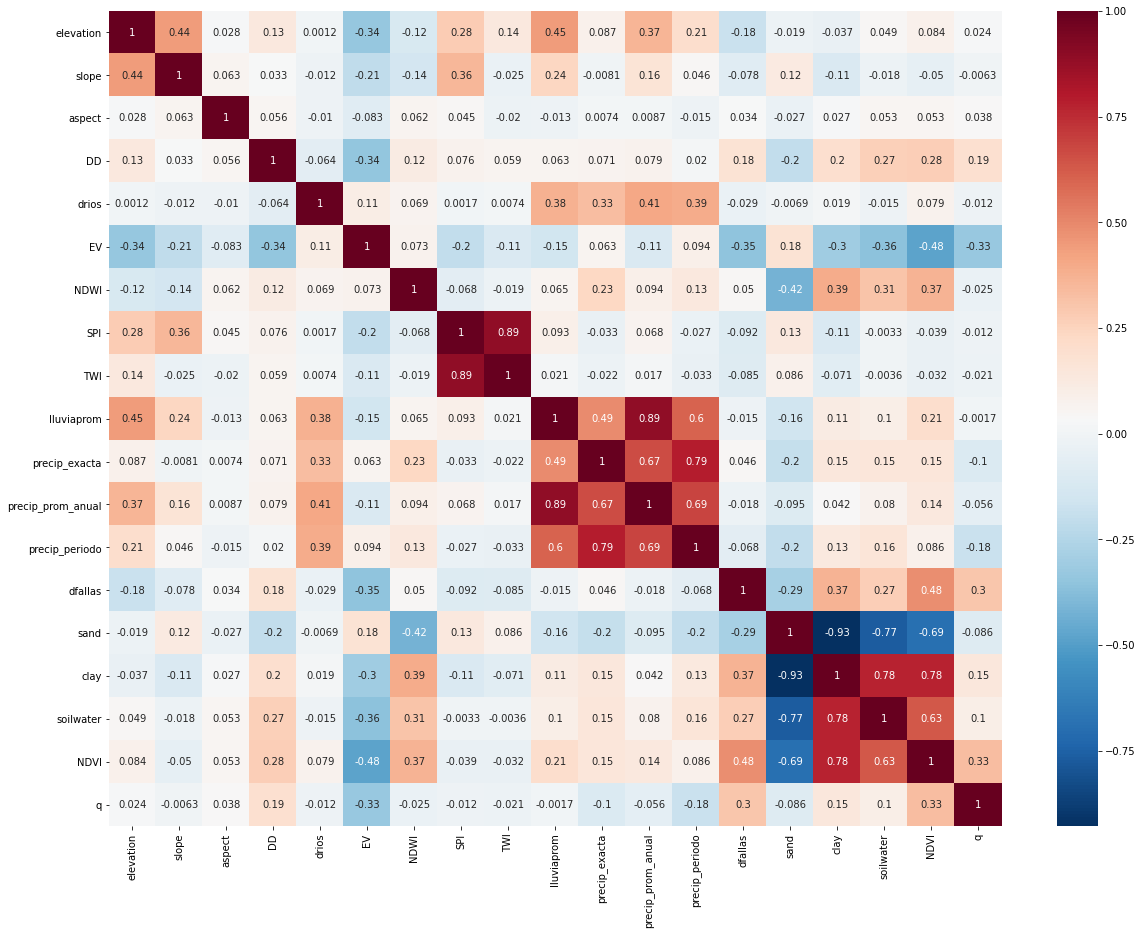

In [ ]:
corrMatrix =df_new_num.corr()
plt.subplots(figsize=(20,15))
sn.heatmap(corrMatrix, annot=True, cmap="RdBu_r")
plt.show()

##### b) Puntaje VIF
Asimismo, se computó el puntaje VIF correspondiente a las variables independientes numéricas. Los resultados se presentan en orden decreciente.


In [ ]:
vif = pd.DataFrame([variance_inflation_factor(df_ind_num.values, i) for i in range(df_ind_num.shape[1])],
                    index=df_ind_num.columns, columns=['Puntaje VIF'])
vif=vif.sort_values(by=['Puntaje VIF'], ascending=False)
vif

Puntaje VIF
TWI                 289.174262
clay                102.838161
sand                 74.726948
SPI                  64.121347
soilwater            29.496580
NDVI                 25.247823
EV                   21.574530
precip_prom_anual    14.226187
lluviaprom           11.691520
slope                 8.083410
NDWI                  6.513241
precip_periodo        5.437349
precip_exacta         5.093345
aspect                4.569610
DD                    2.795220
dfallas               2.690143
elevation             2.210786
drios                 1.349388

#### 1.5.4) Análisis preliminar de importancia de variables



##### a) Algoritmo Relief F
En primer lugar, se empleó el algoritmo Relief F para estimar qué variables explican de mejor manera la clasificación multiclase. Puntajes negativos indican variables que deben ser descartadas.

In [4]:
fs = ReliefF()
fs.fit(df_ind_num.to_numpy(),Y.values.flatten())
relief = pd.DataFrame([fs.feature_importances_],index=['Puntaje Relief F'], columns=df_ind_num.columns).T
relief.sort_values(by=['Puntaje Relief F'], ascending=False)

Puntaje Relief F
EV                         0.124728
NDVI                       0.062799
dfallas                    0.047858
clay                       0.045613
soilwater                  0.043663
aspect                     0.040163
SPI                        0.033795
sand                       0.028092
DD                         0.026940
TWI                        0.025832
elevation                  0.020965
precip_periodo             0.016641
NDWI                       0.015799
precip_exacta              0.012561
precip_prom_anual          0.012471
lluviaprom                 0.012073
slope                      0.005431
drios                      0.001734

##### b) Análisis mediante histogramas

Asimismo, se computaron los histogramas correspondientes para las categorías 0 y 2 de caudal para todas las variables numéricas independientes. Variables donde los histogramas se encuentren más separados se consideran como más adecuadas.

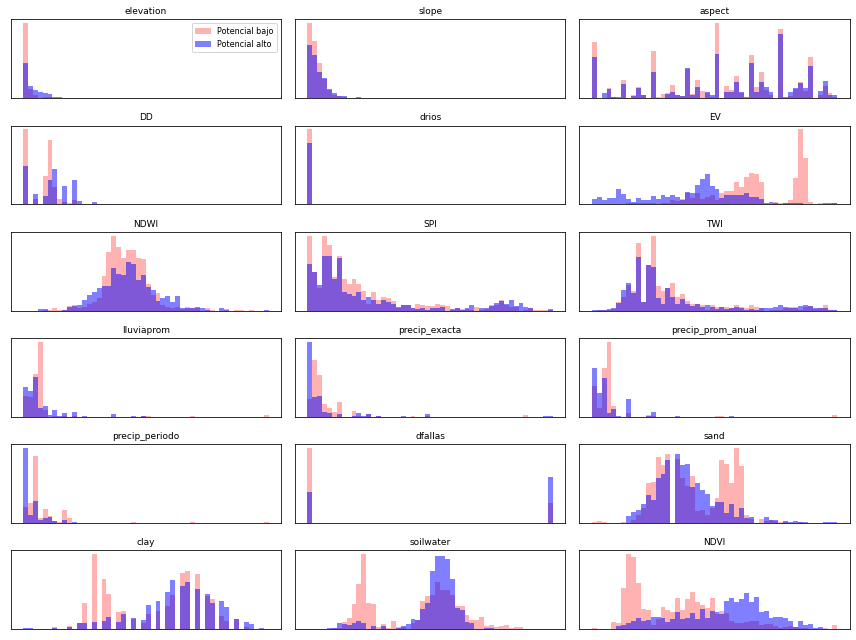

In [ ]:
fig,axes =plt.subplots(6,3, figsize=(12, 9)) # 3 columns each containing 10 figures, total 30 features
cat0=df_ind_num_cat.loc[df_ind_num_cat["qcat"]==0].to_numpy()
cat1=df_ind_num_cat.loc[df_ind_num_cat["qcat"]==1].to_numpy()
cat2=df_ind_num_cat.loc[df_ind_num_cat["qcat"]==2].to_numpy()
ax=axes.ravel()# flat axes with numpy ravel
for i in range(18):
  _,bins=np.histogram(df_ind_num_cat.to_numpy()[:,i],bins=50)
  ax[i].hist(cat0[:,i],bins=bins,color='r',alpha=0.3)
  ax[i].hist(cat2[:,i],bins=bins,color='b',alpha=0.5)
  ax[i].set_title(df_ind_num_cat.columns[i],fontsize=9)
  ax[i].axes.get_xaxis().set_visible(False) 
  ax[i].set_yticks(())
ax[0].legend(['Potencial bajo','Potencial alto'],loc='best',fontsize=8)
plt.tight_layout()# let's make good plots
plt.show()

## 2) Construcción y validación de modelos predictivos

### 2.1) Modelo de bosques aleatorios

#### 2.1.1) Definiciones preliminares

##### a) Definición de bases de datos con origen

In [ ]:
con_origen=pd.concat([X_rf, df[['origen']]], axis=1)
ycon_origen=pd.concat([qcat, df[['origen']]], axis=1)

##### b) Cálculo de métricas rápidas

In [ ]:
def metricas(y_test,y_pred_test):
  print (accuracy_score(y_test,y_pred_test))
  print(confusion_matrix(y_test,y_pred_test))
  print(classification_report(y_test,y_pred_test))

##### c) Función para anotar gráficas

In [ ]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

##### d) Función generar curva ROC

In [ ]:
def curvaROC(y_test, y_score, n_classes, lw):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  thr=dict()
  for i in range(n_classes):
      fpr[i], tpr[i], thr[i] = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  youden = dict()
  distance = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    youden[i] = tpr[i]-fpr[i]
    distance[i] =np.power((np.power(1-tpr[i],2)+np.power(fpr[i],2)), 0.5)
    youdenthr = thr[i][np.argmax(youden[i])]
    youdenmax =  youden[i].max()
    distthr = thr[i][np.argmin(distance[i])]
    distmin =  distance[i].min()  
    print("Para la clase {0}:".format(["C", "B", "A"][i]))
    print("El umbral más adecuado según el máximo índice de Youden es {:.3f} con un valor de {:.3f}".format(youdenthr, youdenmax))
    print("El umbral más adecuado según la mínima distancia es {:.3f} con un valor de {:.3f}".format(distthr, distmin))

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  from itertools import cycle

  plt.figure()
  plt.subplots(figsize=(12,8))
  plt.plot(fpr["micro"], tpr["micro"],
          label='Curva ROC promedio (área = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'cornflowerblue', 'darkblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='Curva ROC para la clase {0} (área = {1:0.2f})'
              ''.format(["C", "B", "A"][i], roc_auc[i]))
      ymax = tpr[i][np.argmax(youden[i])]
      xmax = fpr[i][np.argmax(youden[i])]
      plt.scatter(xmax, ymax, color=color, marker="X", s=200, edgecolors="black",
                  label="Umbral óptimo para la clase {} (TVP={:.2f}, TFP={:.2f})".format(["C", "B", "A"][i],
                                                                                        tpr[i][np.argmax(youden[i])],
                                                                                        fpr[i][np.argmax(youden[i])]))
      

      
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Tasa de falsos positivos')
  plt.ylabel('Tasa de verdaderos positivos')
  plt.legend(loc="lower right")
  plt.show()

#### 2.1.1) Modelo de bosques aleatorios sin segmentación geográfica en la costa y sin reducción de variables

Primero, se seleccionaron únicamente los datos de la costa y se dividió a los mismos en dos grupos: entrenamiento y evaluación. Finalmente, estos datos fueron normalizados.

In [ ]:
#Selección única de datos de la costa
origen=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru", "Lacramarca", "Santa", "Casma", 
        "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon", "Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", 
        "Acari", "Yauca"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=ycon_origen.loc[ycon_origen['origen'].isin(origen)].drop(columns=['origen'])

#División de la base de datos en entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=10)

#Normalización de los datos
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

##### a.) Determinación de hiperparámetros más adecuados
Se determinó el modelo más idóneo en base a un proceso iterativo. Se buscó que las 3 métricas propuestas para la investigación sean maximizadas con los hiperparámetros seleccionados. La base de datos se dividió en dos: entrenamiento y evaluación. Para la construcción y validación de modelos se empleo validación cruzada de 4 divisiones.

In [ ]:
#Parámetros a iterar
n_estimators = list(range (200, 1100, 100))
criterion=['gini', 'entropy']
max_depth = list(range (1, 16, 1))
max_features=["sqrt", "log2"]


hyperF = dict(n_estimators = n_estimators, 
              criterion=criterion,
              max_depth = max_depth,  
              max_features=max_features)

#Optimización iterativa del modelo utilizando validación cruzada
forest = RandomForestClassifier(random_state = 1)
gridF = GridSearchCV(forest, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF = gridF.fit(X_train_norm, y_train)

#Evaluación de datos de evaluación
y_pred_test = bestF.predict(X_test_norm)
metricas(y_test,y_pred_test)

Fitting 4 folds for each of 540 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 48.2min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 64.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.7115839243498818
[[135  11  20]
 [ 38  45  22]
 [ 18  13 121]]
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       166
           1       0.65      0.43      0.52       105
           2       0.74      0.80      0.77       152

    accuracy                           0.71       423
   macro avg       0.70      0.68      0.68       423
weighted avg       0.71      0.71      0.70       423



#####  b.) Análisis de comportamiento: Número de árboles y criterio de impureza
Se computó una gráfica donde se observa cómo varía el desempeño del modelo de acuerdo al número de árboles para los criterios de Gini y Entropía usando únicamente los datos de entrenamiento y validación cruzada

In [ ]:
#Parámetros a iterar
n_estimators = list(range (50, 1050, 50))

hyperF = dict(n_estimators = n_estimators)

#Optimización iterativa del modelo utilizando validación cruzada para Gini
forest = RandomForestClassifier(random_state = 1,
                                criterion='gini',
                                max_depth=8,
                                max_features="sqrt")
gridF2 = GridSearchCV(forest, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF2 = gridF2.fit(X_train_norm, y_train)

#Optimización iterativa del modelo utilizando validación cruzada para Entropía
forest2 = RandomForestClassifier(random_state = 1,
                                criterion='entropy',
                                max_depth=8,
                                max_features="sqrt")
gridF3 = GridSearchCV(forest2, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF3 = gridF3.fit(X_train_norm, y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


###### Métrica: Exactitud


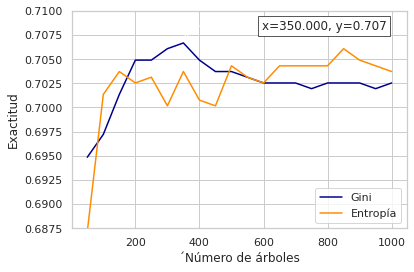

In [ ]:
#Gráfico de Exactitud
ntrees = list(range (50, 1050, 50))
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ntrees, gridF2.cv_results_["mean_test_accuracy"], label="Gini", color='darkblue')
ax.plot(ntrees, gridF3.cv_results_["mean_test_accuracy"], label="Entropía", color='darkorange')
ax.legend(loc="lower right")
ax.set_ylabel('Exactitud', fontname="Times New Roman")
ax.set_xlabel('´Número de árboles', fontname="Times New Roman")
annot_max(ntrees,gridF2.cv_results_["mean_test_accuracy"],ax)
ax.set_ylim(0.6875,0.71)
plt.show()

###### Métrica: Puntaje F1

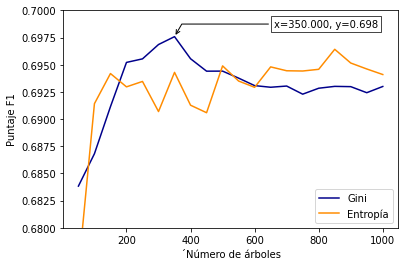

In [ ]:
#Gráfico de F1
ntrees = list(range (50, 1050, 50))
fig, ax = plt.subplots()
ax.plot(ntrees, gridF2.cv_results_["mean_test_f1_weighted"], label="Gini", color='darkblue')
ax.plot(ntrees, gridF3.cv_results_["mean_test_f1_weighted"], label="Entropía", color='darkorange')
ax.set_ylabel('Puntaje F1', fontname="Times New Roman")
ax.set_xlabel('´Número de árboles', fontname="Times New Roman")
ax.legend(loc="lower right")
annot_max(ntrees,gridF2.cv_results_["mean_test_f1_weighted"],ax)
ax.set_ylim(0.68,0.70)
plt.show()

###### Métrica: AUROC

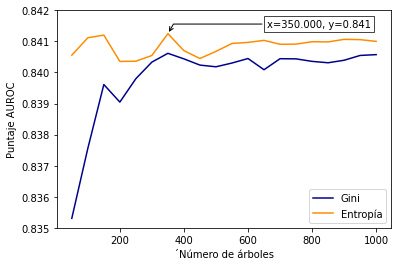

In [ ]:
#Gráfico de AUROC
ntrees = list(range (50, 1050, 50))
fig, ax = plt.subplots()
ax.plot(ntrees, gridF2.cv_results_["mean_test_roc_auc_ovr_weighted"], label="Gini", color='darkblue')
ax.plot(ntrees, gridF3.cv_results_["mean_test_roc_auc_ovr_weighted"], label="Entropía", color='darkorange')
ax.set_ylabel('Puntaje AUROC', fontname="Times New Roman")
ax.set_xlabel('´Número de árboles', fontname="Times New Roman")
ax.legend(loc="lower right")
annot_max(ntrees,gridF3.cv_results_["mean_test_roc_auc_ovr_weighted"],ax)
ax.set_ylim(0.835,0.842)
plt.show()

##### c.) Exatitud, puntaje F1 e importancia de variables
Se determinó el desempeño del modelo según las métricas no dependientes del umbral (exactitud y puntaje F1) para los datos de evaluación. Asimismo, se presentan las variables en orden decreciente de acuerdo con el modelo.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


0.7210401891252955
[[136  10  20]
 [ 38  47  20]
 [ 16  14 122]]
              precision    recall  f1-score   support

           0       0.72      0.82      0.76       166
           1       0.66      0.45      0.53       105
           2       0.75      0.80      0.78       152

    accuracy                           0.72       423
   macro avg       0.71      0.69      0.69       423
weighted avg       0.72      0.72      0.71       423



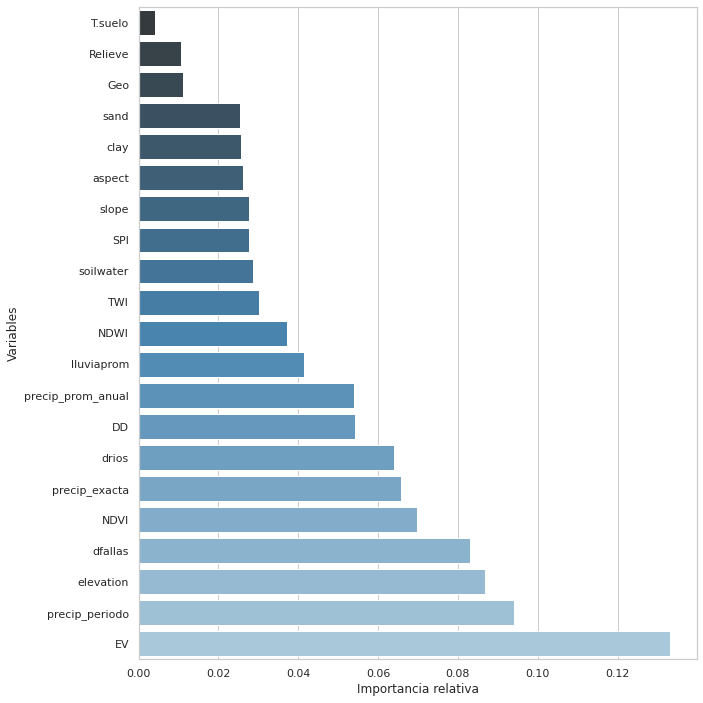

In [ ]:
model = RandomForestClassifier(n_estimators=350,
                               criterion="gini",
                               max_depth=8,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               min_weight_fraction_leaf=0,
                               max_features = "sqrt",
                               max_leaf_nodes=None,
                               min_impurity_decrease=0,
                               bootstrap = True,
                               oob_score=True,
                               n_jobs=None,
                               random_state=1,
                               verbose=0,
                               warm_start=False,
                               class_weight=None,
                               ccp_alpha=0,
                               max_samples=None)    
model.fit(X_train_norm, y_train.values.ravel())
y_pred_test = model.predict(X_test_norm)
metricas(y_test,y_pred_test)
importances = model.feature_importances_
indices = np.argsort(importances)
impplot=pd.DataFrame({'Variables':[X_clust.columns[i] for i in indices], 
                      'Importancia relativa': importances[indices]})
sn.set(rc={'figure.figsize':(10,12)}, font='Times New Roman',style="whitegrid")
ax = sn.barplot(y='Variables',x='Importancia relativa', data=impplot,palette='Blues_d')

##### d) Construcción de curvas ROC
Se computaron las curvas ROC por categoría para analizar el desempeño del modelo sin tomar en cuenta el umbral de clasificación

Para la clase C:
El umbral más adecuado según el máximo índice de Youden es 0.498 con un valor de 0.606
El umbral más adecuado según la mínima distancia es 0.498 con un valor de 0.284
Para la clase B:
El umbral más adecuado según el máximo índice de Youden es 0.281 con un valor de 0.361
El umbral más adecuado según la mínima distancia es 0.281 con un valor de 0.458
Para la clase A:
El umbral más adecuado según el máximo índice de Youden es 0.420 con un valor de 0.682
El umbral más adecuado según la mínima distancia es 0.400 con un valor de 0.232


<Figure size 720x864 with 0 Axes>

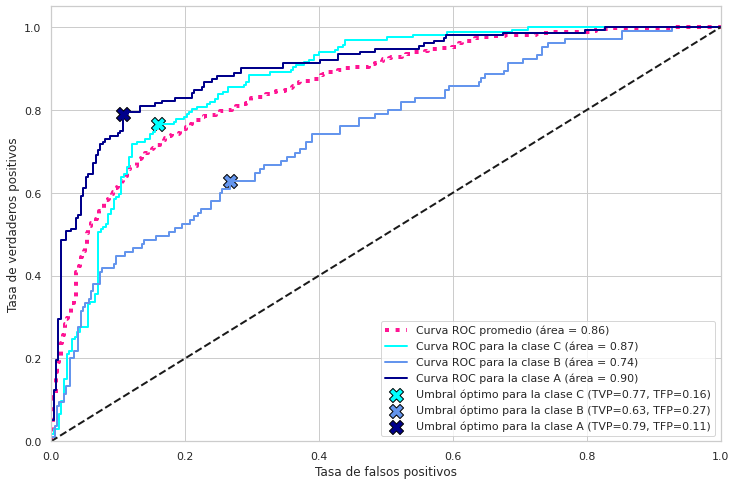

In [ ]:
YROC = label_binarize(Y_clust, classes=[0, 1, 2])
lw = 2
X_train, X_test, y_train, y_test = train_test_split(X_clust, YROC, test_size=0.20, random_state=10)
n_classes = YROC.shape[1]
classifier = OneVsRestClassifier(model)
y_score = classifier.fit(X_train_norm, y_train).predict_proba(X_test_norm)
curvaROC(y_test, y_score, 3, 2)

#### 2.1.2) Modelo de bosques aleatorios sin segmentación geográfica en la costa con variables reducidas

##### a.) Selección de variables
Se descartaron las variables con problemas de multicolinearidad y se eligieron las 8 mejores luego de un proceso iterativo

In [ ]:
#Selección única de datos de la costa
origen=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru", "Lacramarca", "Santa", "Casma", 
        "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon", "Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", 
        "Acari", "Yauca"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=ycon_origen.loc[ycon_origen['origen'].isin(origen)].drop(columns=['origen'])
X_clust=X_clust[["aspect", "DD", "elevation", "NDWI", "precip_periodo",
                 "precip_exacta", "precip_prom_anual", "lluviaprom"]]
Y_clust=ycon_origen.loc[ycon_origen['origen'].isin(origen)].drop(columns=['origen'])

#División de la base de datos en entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=10)

#Normalización de los datos
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

##### b.) Determinación de hiperparámetros más adecuados
Se determinó el modelo más idóneo en base a un proceso iterativo. Se buscó que las 3 métricas propuestas para la investigación sean maximizadas con los hiperparámetros seleccionados. La base de datos se dividió en dos: entrenamiento y evaluación. Para la construcción y validación de modelos se empleo validación cruzada de 4 divisiones.

In [ ]:
#Parámetros a iterar
n_estimators = list(range (200, 1100, 100))
criterion=['gini', 'entropy']
max_depth = list(range (1, 16, 1))
max_features=["sqrt", "log2"]


hyperF = dict(n_estimators = n_estimators, 
              criterion=criterion,
              max_depth = max_depth,  
              max_features=max_features)

#Optimización iterativa del modelo utilizando validación cruzada
forest = RandomForestClassifier(random_state = 1)
gridF = GridSearchCV(forest, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF = gridF.fit(X_train_norm, y_train)

#Evaluación de datos de evaluación
y_pred_test = bestF.predict(X_test_norm)
metricas(y_test,y_pred_test)

Fitting 4 folds for each of 540 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 48.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.7044917257683215
[[136  11  19]
 [ 38  43  24]
 [ 21  12 119]]
              precision    recall  f1-score   support

           0       0.70      0.82      0.75       166
           1       0.65      0.41      0.50       105
           2       0.73      0.78      0.76       152

    accuracy                           0.70       423
   macro avg       0.69      0.67      0.67       423
weighted avg       0.70      0.70      0.69       423



In [ ]:
gridF.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
gridF.best_score_

0.6978140790785744

##### c.) Análisis de comportamiento: número de árboles y criterio de impureza
Se determinó el desempeño del modelo según las métricas no dependientes del umbral (exactitud y puntaje F1) para los datos de evaluación. Asimismo, se presentan las variables en orden decreciente de acuerdo con el modelo.

In [ ]:
#Parámetros a iterar
n_estimators = list(range (50, 1050, 50))

hyperF = dict(n_estimators = n_estimators)

#Optimización iterativa del modelo utilizando validación cruzada para Gini
forest = RandomForestClassifier(random_state = 1,
                                criterion='gini',
                                max_depth=7,
                                max_features="sqrt")
gridF2 = GridSearchCV(forest, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF2 = gridF2.fit(X_train_norm, y_train)

#Optimización iterativa del modelo utilizando validación cruzada para Entropía
forest2 = RandomForestClassifier(random_state = 1,
                                criterion='entropy',
                                max_depth=7,
                                max_features="sqrt")
gridF3 = GridSearchCV(forest2, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF3 = gridF3.fit(X_train_norm, y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


###### Métrica: Exactitud


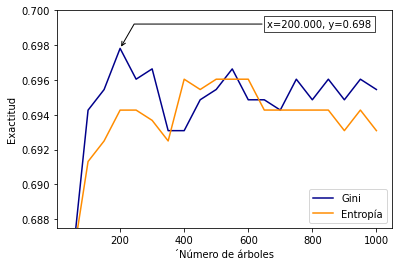

In [ ]:
#Gráfico de Exactitud
ntrees = list(range (50, 1050, 50))
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ntrees, gridF2.cv_results_["mean_test_accuracy"], label="Gini", color='darkblue')
ax.plot(ntrees, gridF3.cv_results_["mean_test_accuracy"], label="Entropía", color='darkorange')
ax.legend(loc="lower right")
ax.set_ylabel('Exactitud', fontname="Times New Roman")
ax.set_xlabel('´Número de árboles', fontname="Times New Roman")
annot_max(ntrees,gridF2.cv_results_["mean_test_accuracy"],ax)
ax.set_ylim(0.6875,0.70)
plt.show()

###### Métrica: Puntaje F1

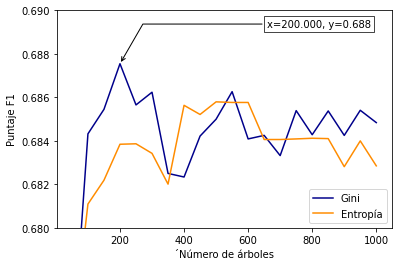

In [ ]:
#Gráfico de F1
ntrees = list(range (50, 1050, 50))
fig, ax = plt.subplots()
ax.plot(ntrees, gridF2.cv_results_["mean_test_f1_weighted"], label="Gini", color='darkblue')
ax.plot(ntrees, gridF3.cv_results_["mean_test_f1_weighted"], label="Entropía", color='darkorange')
ax.set_ylabel('Puntaje F1', fontname="Times New Roman")
ax.set_xlabel('´Número de árboles', fontname="Times New Roman")
ax.legend(loc="lower right")
annot_max(ntrees,gridF2.cv_results_["mean_test_f1_weighted"],ax)
ax.set_ylim(0.68,0.69)
plt.show()

###### Métrica: AUROC

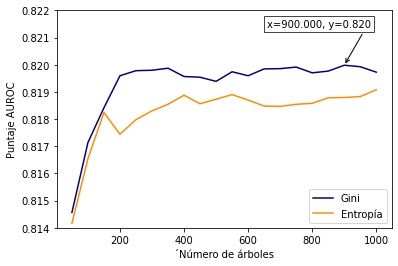

In [ ]:
#Gráfico de AUROC
ntrees = list(range (50, 1050, 50))
fig, ax = plt.subplots()
ax.plot(ntrees, gridF2.cv_results_["mean_test_roc_auc_ovr_weighted"], label="Gini", color='darkblue')
ax.plot(ntrees, gridF3.cv_results_["mean_test_roc_auc_ovr_weighted"], label="Entropía", color='darkorange')
ax.set_ylabel('Puntaje AUROC', fontname="Times New Roman")
ax.set_xlabel('´Número de árboles', fontname="Times New Roman")
ax.legend(loc="lower right")
annot_max(ntrees,gridF2.cv_results_["mean_test_roc_auc_ovr_weighted"],ax)
ax.set_ylim(0.814,0.822)
plt.show()

##### d.) Influencia de precipitación en los modelos

In [ ]:
#Parámetros a iterar
n_estimators = list(range (50, 1050, 50))

hyperF = dict(n_estimators = n_estimators)

forest = RandomForestClassifier(random_state = 1,
                                criterion='gini',
                                max_depth=7,
                                max_features="sqrt")

#Optimización iterativa del modelo utilizando validación cruzada para precipitación exacta
gridF2 = GridSearchCV(forest, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF2 = gridF2.fit(X_train_norm[["aspect", "DD", "elevation", "NDWI",
                                 "precip_exacta"]], y_train)

#Optimización iterativa del modelo utilizando validación cruzada para precipitación promedio anual
gridF3 = GridSearchCV(forest, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF3 = gridF3.fit(X_train_norm[["aspect", "DD", "elevation", "NDWI",
                                 "precip_prom_anual"]], y_train)


#Optimización iterativa del modelo utilizando validación cruzada para precipitación en periodo
gridF4 = GridSearchCV(forest, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF4 = gridF4.fit(X_train_norm[["aspect", "DD", "elevation", "NDWI",
                                 "precip_periodo"]], y_train)


#Optimización iterativa del modelo utilizando validación cruzada para precipitación global
gridF5 = GridSearchCV(forest, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF5 = gridF5.fit(X_train_norm[["aspect", "DD", "elevation", "NDWI",
                                 "lluviaprom"]], y_train)

#Optimización iterativa del modelo utilizando validación cruzada para todas las variables de precipitación
gridF6 = GridSearchCV(forest, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF6 = gridF6.fit(X_train_norm[["aspect", "DD", "elevation", "NDWI", "precip_periodo",
                                 "precip_exacta", "precip_prom_anual", "lluviaprom"]], y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


###### Métrica: Exactitud

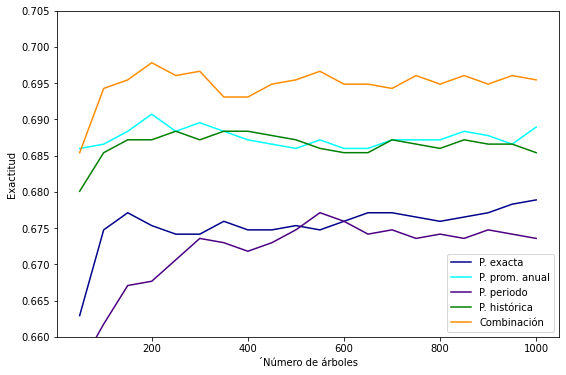

In [ ]:
#Gráfico de Exactitud
ntrees = list(range (50, 1050, 50))
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(ntrees, gridF2.cv_results_["mean_test_accuracy"], label="P. exacta", color='darkblue')
ax.plot(ntrees, gridF3.cv_results_["mean_test_accuracy"], label="P. prom. anual", color='aqua')
ax.plot(ntrees, gridF4.cv_results_["mean_test_accuracy"], label="P. periodo", color='indigo')
ax.plot(ntrees, gridF5.cv_results_["mean_test_accuracy"], label="P. histórica", color='green')
ax.plot(ntrees, gridF6.cv_results_["mean_test_accuracy"], label="Combinación", color='darkorange')
ax.legend(loc="lower right")
ax.set_ylabel('Exactitud', fontname="Times New Roman")
ax.set_xlabel('´Número de árboles', fontname="Times New Roman")
ax.set_ylim(0.66,0.705)
plt.show()

###### Métrica: Puntaje F1

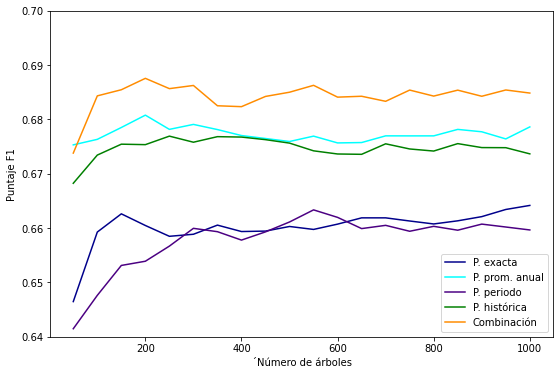

In [ ]:
#Gráfico de Exactitud
ntrees = list(range (50, 1050, 50))
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(ntrees, gridF2.cv_results_["mean_test_f1_weighted"], label="P. exacta", color='darkblue')
ax.plot(ntrees, gridF3.cv_results_["mean_test_f1_weighted"], label="P. prom. anual", color='aqua')
ax.plot(ntrees, gridF4.cv_results_["mean_test_f1_weighted"], label="P. periodo", color='indigo')
ax.plot(ntrees, gridF5.cv_results_["mean_test_f1_weighted"], label="P. histórica", color='green')
ax.plot(ntrees, gridF6.cv_results_["mean_test_f1_weighted"], label="Combinación", color='darkorange')
ax.legend(loc="lower right")
ax.set_ylabel('Puntaje F1', fontname="Times New Roman")
ax.set_xlabel('´Número de árboles', fontname="Times New Roman")
ax.set_ylim(0.64,0.70)
plt.show()

###### Métrica: AUROC

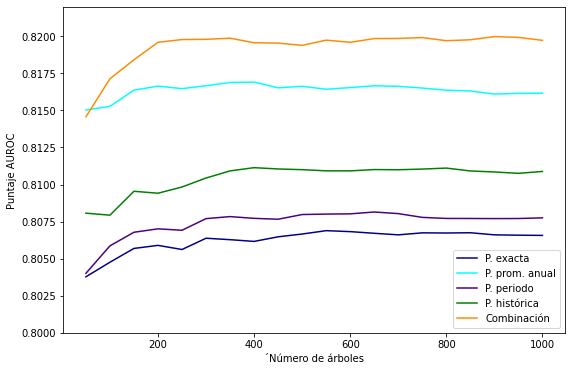

In [ ]:
#Gráfico de Exactitud
ntrees = list(range (50, 1050, 50))
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(ntrees, gridF2.cv_results_["mean_test_roc_auc_ovr_weighted"], label="P. exacta", color='darkblue')
ax.plot(ntrees, gridF3.cv_results_["mean_test_roc_auc_ovr_weighted"], label="P. prom. anual", color='aqua')
ax.plot(ntrees, gridF4.cv_results_["mean_test_roc_auc_ovr_weighted"], label="P. periodo", color='indigo')
ax.plot(ntrees, gridF5.cv_results_["mean_test_roc_auc_ovr_weighted"], label="P. histórica", color='green')
ax.plot(ntrees, gridF6.cv_results_["mean_test_roc_auc_ovr_weighted"], label="Combinación", color='darkorange')
ax.legend(loc="lower right")
ax.set_ylabel('Puntaje AUROC', fontname="Times New Roman")
ax.set_xlabel('´Número de árboles', fontname="Times New Roman")
ax.set_ylim(0.8,0.822)
plt.show()

##### e.) Exatitud, puntaje F1 e importancia de variables
Se determinó el desempeño del modelo según las métricas no dependientes del umbral (exactitud y puntaje F1). Asimismo, se presentan las variables en orden decreciente

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


0.7044917257683215
[[136  11  19]
 [ 38  43  24]
 [ 21  12 119]]
              precision    recall  f1-score   support

           0       0.70      0.82      0.75       166
           1       0.65      0.41      0.50       105
           2       0.73      0.78      0.76       152

    accuracy                           0.70       423
   macro avg       0.69      0.67      0.67       423
weighted avg       0.70      0.70      0.69       423



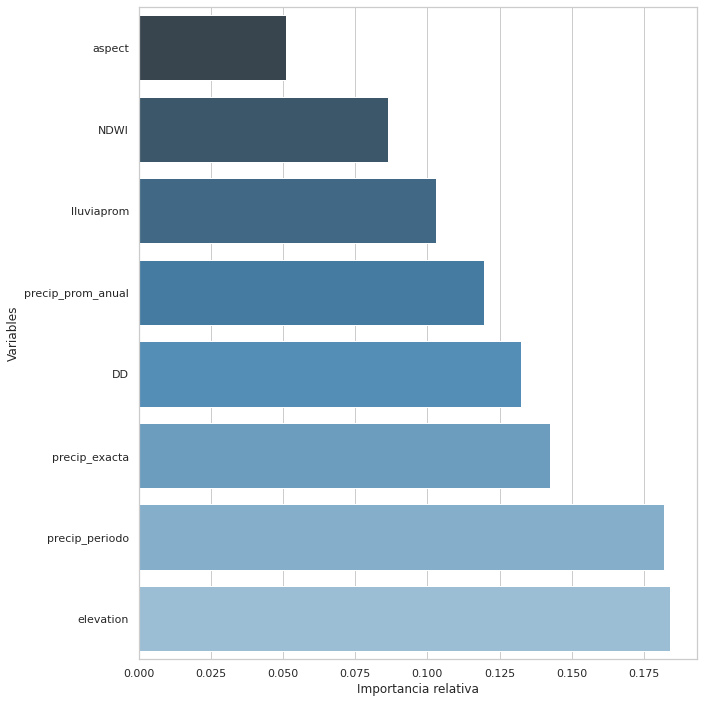

In [ ]:
model = RandomForestClassifier(n_estimators=200,
                               criterion="gini",
                               max_depth=7,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               min_weight_fraction_leaf=0,
                               max_features = "sqrt",
                               max_leaf_nodes=None,
                               min_impurity_decrease=0,
                               bootstrap = True,
                               oob_score=True,
                               n_jobs=None,
                               random_state=1,
                               verbose=0,
                               warm_start=False,
                               class_weight=None,
                               ccp_alpha=0,
                               max_samples=None)    
model.fit(X_train_norm, y_train.values.ravel())
y_pred_test = model.predict(X_test_norm)
metricas(y_test,y_pred_test)
importances = model.feature_importances_
indices = np.argsort(importances)
impplot=pd.DataFrame({'Variables':[X_clust.columns[i] for i in indices], 
                      'Importancia relativa': importances[indices]})
sn.set(rc={'figure.figsize':(10,12)}, font='Times New Roman',style="whitegrid")
ax = sn.barplot(y='Variables',x='Importancia relativa', data=impplot,palette='Blues_d')

##### f) Construcción de curvas ROC
Se computaron las curvas ROC por categoría para analizar el desempeño del modelo sin tomar en cuenta el umbral de clasificación

Para la clase C:
El umbral más adecuado según el máximo índice de Youden es 0.378 con un valor de 0.563
El umbral más adecuado según la mínima distancia es 0.378 con un valor de 0.309
Para la clase B:
El umbral más adecuado según el máximo índice de Youden es 0.339 con un valor de 0.360
El umbral más adecuado según la mínima distancia es 0.297 con un valor de 0.502
Para la clase A:
El umbral más adecuado según el máximo índice de Youden es 0.485 con un valor de 0.690
El umbral más adecuado según la mínima distancia es 0.469 con un valor de 0.244


<Figure size 720x864 with 0 Axes>

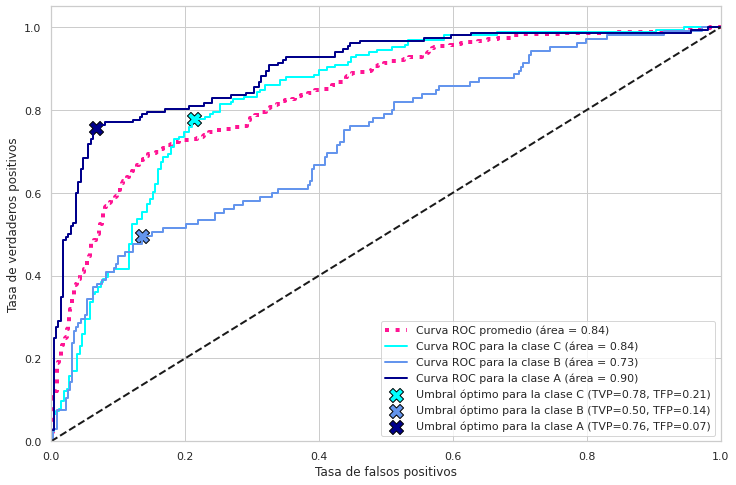

In [ ]:
YROC = label_binarize(Y_clust, classes=[0, 1, 2])
X_train, X_test, y_train, y_test = train_test_split(X_clust, YROC, test_size=0.20, random_state=10)
n_classes = YROC.shape[1]
classifier = OneVsRestClassifier(model)
y_score = classifier.fit(X_train_norm, y_train).predict_proba(X_test_norm)
curvaROC(y_test, y_score, 3, 2)

#### 2.1.3) Modelo de bosques aleatorios con segmentación geográfica para la costa sur

##### a) Selección de pozos
Pimero se seleciconan únicamente los pozos correspondientes a esta segmentación. Los valores de caudal se recategorizan de acuerdo a los datos disponibles.


In [ ]:
#Selección única de datos de la costa sur
origentodos=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru", "Lacramarca", "Santa", "Casma", 
        "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon", "Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", 
        "Acari", "Yauca"]
origen=["Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", "Acari", "Yauca"]

X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])

Y_clust=df.loc[df['origen'].isin(origen)][['q']]
Y_clust=pd.qcut(Y_clust.values.flatten(), 3, labels=False, duplicates="drop")
Y_clust=pd.DataFrame([Y_clust], index=['qcat']).T
clases=Y_clust['qcat'].value_counts().rename_axis('unique_values').reset_index(name='counts')

#División de la base de datos en entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=2)

#Normalización de los datos
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

Text(0.5, 0, 'Cantidad de pozos')

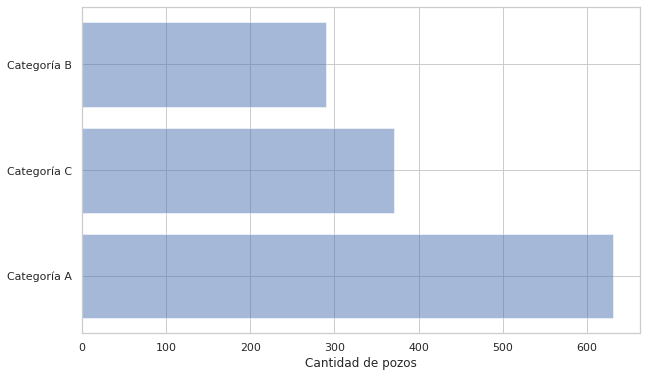

In [ ]:
plt.figure(figsize=(10,6))
objects = ("Categoría A", "Categoría C", "Categoría B")
y_pos = np.arange(len(objects))
cantidad = clases['counts']
plt.barh(y_pos, cantidad, align='center', alpha=0.5)
plt.yticks(y_pos, objects, fontname="Times New Roman")
plt.xlabel('Cantidad de pozos', fontname="Times New Roman")

##### b.) Determinación de hiperparámetros más adecuados
Nuevamente, se realiza utilizando validación cruzada de 4 grupos

In [ ]:
#Parámetros a iterar
n_estimators = list(range (200, 1100, 100))
criterion=['gini', 'entropy']
max_depth = list(range (1, 15, 1))
max_features=["sqrt", "log2"]
hyperF = dict(n_estimators = n_estimators, 
              max_depth = max_depth,  
              max_features=max_features)

#Optimización iterativa del modelo utilizando validación cruzada
forest = RandomForestClassifier(random_state = 0)
gridF = GridSearchCV(forest, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF = gridF.fit(X_train_norm, y_train)

#Evaluación de datos de evaluación
y_pred_test = bestF.predict(X_test_norm)
metricas(y_test,y_pred_test)

Fitting 4 folds for each of 252 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed: 18.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.7683397683397684
[[135   0   5]
 [ 28  11  10]
 [ 15   2  53]]
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       140
           1       0.85      0.22      0.35        49
           2       0.78      0.76      0.77        70

    accuracy                           0.77       259
   macro avg       0.79      0.65      0.66       259
weighted avg       0.78      0.77      0.73       259



In [ ]:
gridF.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

##### c.) Exatitud, puntaje F1 e importancia de variables
Se determinó el desempeño del modelo según las métricas no dependientes del umbral (exactitud y puntaje F1). Asimismo, se presentan las variables en orden creciente

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


0.7683397683397684
[[135   0   5]
 [ 28  11  10]
 [ 15   2  53]]
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       140
           1       0.85      0.22      0.35        49
           2       0.78      0.76      0.77        70

    accuracy                           0.77       259
   macro avg       0.79      0.65      0.66       259
weighted avg       0.78      0.77      0.73       259



findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


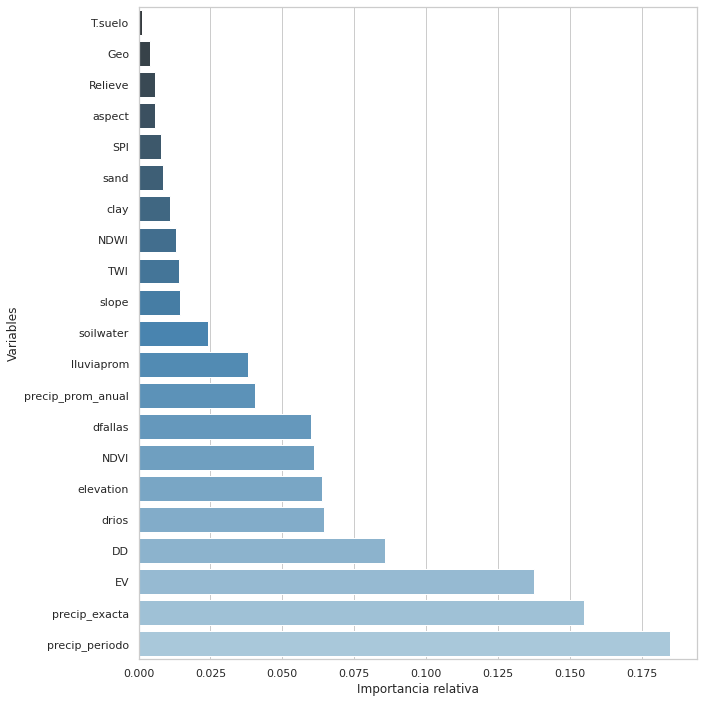

In [ ]:
model = RandomForestClassifier(n_estimators=800,
                               criterion="gini",
                               max_depth=4,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               min_weight_fraction_leaf=0,
                               max_features = "sqrt",
                               max_leaf_nodes=None,
                               min_impurity_decrease=0,
                               bootstrap = True,
                               oob_score=True,
                               n_jobs=None,
                               random_state=0,
                               verbose=0,
                               warm_start=False,
                               class_weight=None,
                               ccp_alpha=0,
                               max_samples=None)       
model.fit(X_train_norm, y_train.values.ravel())
y_pred_test = model.predict(X_test_norm)
metricas(y_test,y_pred_test)
importances = model.feature_importances_
indices = np.argsort(importances)
impplot=pd.DataFrame({'Variables':[X_clust.columns[i] for i in indices], 
                      'Importancia relativa': importances[indices]})
sn.set(rc={'figure.figsize':(10,12)}, font='Times New Roman',style="whitegrid")
ax = sn.barplot(y='Variables',x='Importancia relativa', data=impplot,palette='Blues_d')

##### d) Construcción de curvas ROC
Se computaron las curvas ROC por categoría para analizar el desempeño del modelo independientemente del umbral de decisión seleccionado. En simultáneo, se calcularon los umbrales óptimos.


Para la clase C:
El umbral más adecuado según el máximo índice de Youden es 0.510 con un valor de 0.626
El umbral más adecuado según la mínima distancia es 0.510 con un valor de 0.311
Para la clase B:
El umbral más adecuado según el máximo índice de Youden es 0.263 con un valor de 0.283
El umbral más adecuado según la mínima distancia es 0.241 con un valor de 0.540
Para la clase A:
El umbral más adecuado según el máximo índice de Youden es 0.482 con un valor de 0.703
El umbral más adecuado según la mínima distancia es 0.308 con un valor de 0.220


<Figure size 720x864 with 0 Axes>

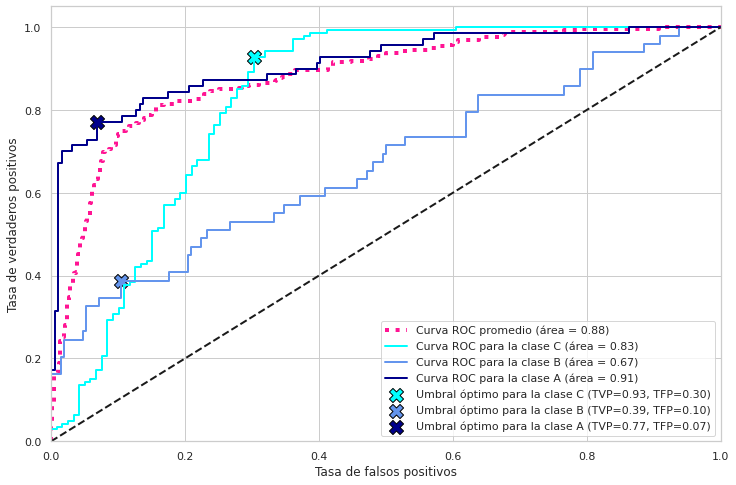

In [ ]:
YROC = label_binarize(Y_clust, classes=[0, 1, 2])
X_train, X_test, y_train, y_test = train_test_split(X_clust, YROC, test_size=0.20, random_state=2)
n_classes = YROC.shape[1]
classifier = OneVsRestClassifier(model)
y_score = classifier.fit(X_train_norm, y_train).predict_proba(X_test_norm)
curvaROC(y_test, y_score, 3, 2)

#### 2.1.4) Modelo de bosques aleatorios con segmentación geográfica para la costa centro

##### a.) Selección de pozos
Se emplearon únicamente los pozos identificados por K medias para la región centro

In [ ]:
#Selección única de datos de la costa centro
origentodos=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru", "Lacramarca", "Santa", "Casma", 
        "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon", "Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", 
        "Acari", "Yauca"]
origen=["Lacramarca", "Santa", "Casma", "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon"]

X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])

Y_clust=df.loc[df['origen'].isin(origen)][['q']]
Y_clust=pd.qcut(Y_clust.values.flatten(), 2, labels=False, duplicates="drop")
Y_clust=pd.DataFrame([Y_clust], index=['qcat']).T
clases=Y_clust['qcat'].value_counts().rename_axis('unique_values').reset_index(name='counts')

#División de la base de datos en entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=0)

#Normalización de los datos
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

Text(0.5, 0, 'Cantidad de pozos')

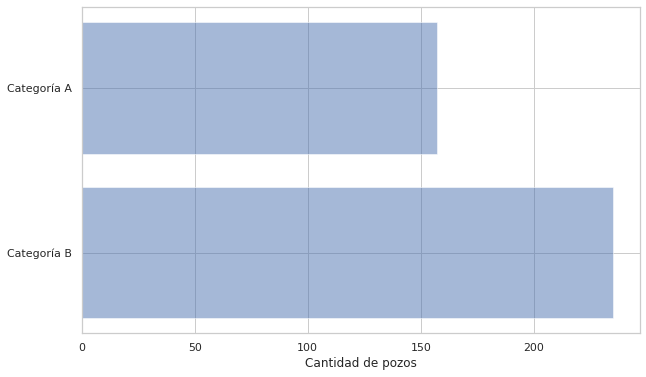

In [ ]:
plt.figure(figsize=(10,6))
objects = ("Categoría B", "Categoría A")
y_pos = np.arange(len(objects))
cantidad = clases['counts']
plt.barh(y_pos, cantidad, align='center', alpha=0.5)
plt.yticks(y_pos, objects, fontname="Times New Roman")
plt.xlabel('Cantidad de pozos', fontname="Times New Roman")

##### b.) Determinación de hiperparámetros más adecuados
Nuevamente, se realiza utilizando validación cruzada de 4 grupos

In [ ]:
#Parámetros a iterar
n_estimators = list(range (200, 1100, 100))
criterion=['gini', 'entropy']
max_depth = list(range (1, 15, 1))
max_features=["sqrt", "log2"]
hyperF = dict(n_estimators = n_estimators, 
              max_depth = max_depth,  
              max_features=max_features)

#Optimización iterativa del modelo utilizando validación cruzada
forest = RandomForestClassifier(random_state = 0)
gridF = GridSearchCV(forest, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF = gridF.fit(X_train_norm, y_train)

#Evaluación de datos de evaluación
y_pred_test = bestF.predict(X_test_norm)
metricas(y_test,y_pred_test)

Fitting 4 folds for each of 252 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed: 14.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.810126582278481
[[43  3]
 [12 21]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        46
           1       0.88      0.64      0.74        33

    accuracy                           0.81        79
   macro avg       0.83      0.79      0.79        79
weighted avg       0.82      0.81      0.80        79



In [ ]:
gridF.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

##### c.) Exatitud, puntaje F1 e importancia de variables
Se determinó el desempeño del modelo según las métricas no dependientes del umbral (exactitud y puntaje F1). Asimismo, se presentan las variables en orden creciente

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


0.810126582278481
[[43  3]
 [12 21]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        46
           1       0.88      0.64      0.74        33

    accuracy                           0.81        79
   macro avg       0.83      0.79      0.79        79
weighted avg       0.82      0.81      0.80        79



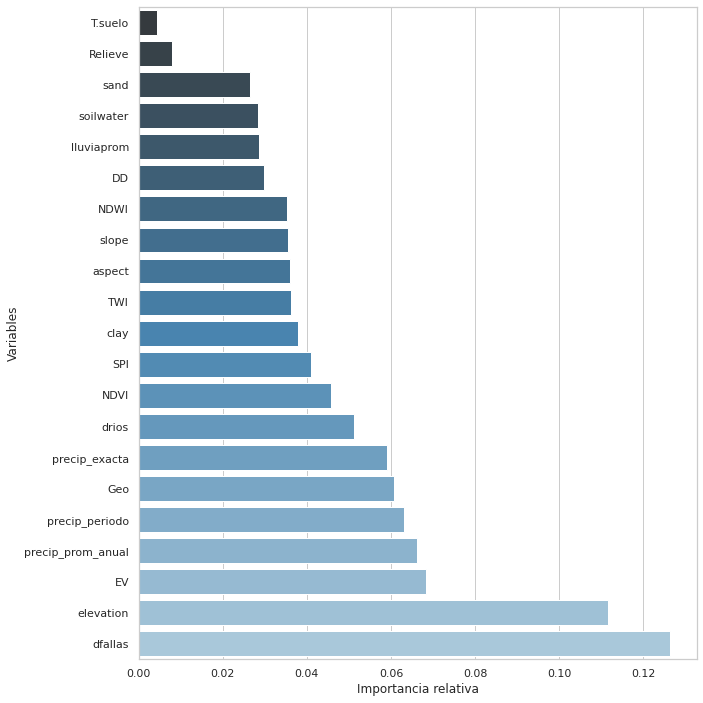

In [ ]:
model = RandomForestClassifier(n_estimators=600,
                               criterion="gini",
                               max_depth=5,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               min_weight_fraction_leaf=0,
                               max_features = "sqrt",
                               max_leaf_nodes=None,
                               min_impurity_decrease=0,
                               bootstrap = True,
                               oob_score=True,
                               n_jobs=None,
                               random_state=0,
                               verbose=0,
                               warm_start=False,
                               class_weight=None,
                               ccp_alpha=0,
                               max_samples=None)       
model.fit(X_train_norm, y_train.values.ravel())
y_pred_test = model.predict(X_test_norm)
metricas(y_test,y_pred_test)
importances = model.feature_importances_
indices = np.argsort(importances)
impplot=pd.DataFrame({'Variables':[X_clust.columns[i] for i in indices], 
                      'Importancia relativa': importances[indices]})
sn.set(rc={'figure.figsize':(10,12)}, font='Times New Roman',style="whitegrid")
ax = sn.barplot(y='Variables',x='Importancia relativa', data=impplot,palette='Blues_d')

##### d) Construcción de curvas ROC
Se computaron las curvas ROC por categoría para analizar el desempeño del modelo independientemente del umbral de decisión seleccionado. En simultáneo, se calcularon los umbrales óptimos.


Para el problema de clasificación binaria
El umbral más adecuado según el máximo índice de Youden es 0.443 con un valor de 0.640
El umbral más adecuado según la mínima distancia es 0.411 con un valor de 0.286


<Figure size 720x864 with 0 Axes>

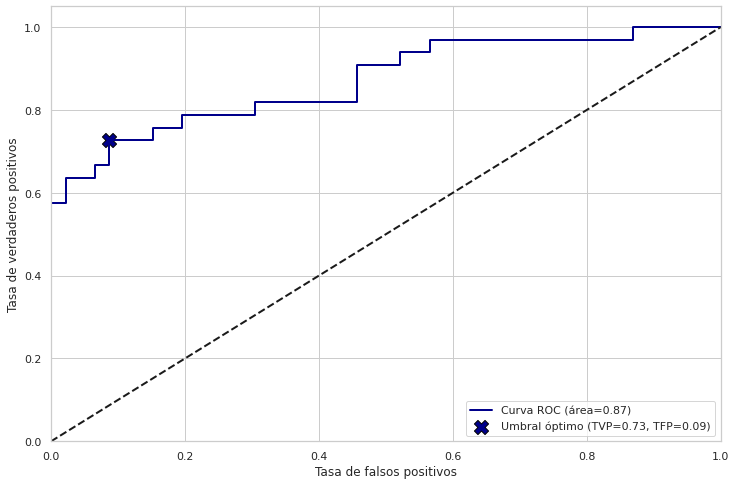

In [ ]:
y_score = model.predict_proba(X_test_norm)
fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)
youden = tpr-fpr
distance =np.power((np.power(1-tpr,2)+np.power(fpr,2)), 0.5)
youdenthr = thr[np.argmax(youden)]
youdenmax =  youden.max()
distthr = thr[np.argmin(distance)]
distmin =  distance.min()  
print("Para el problema de clasificación binaria")
print("El umbral más adecuado según el máximo índice de Youden es {:.3f} con un valor de {:.3f}".format(youdenthr, youdenmax))
print("El umbral más adecuado según la mínima distancia es {:.3f} con un valor de {:.3f}".format(distthr, distmin))

plt.figure()
plt.subplots(figsize=(12,8))
plt.plot(fpr, tpr, color="darkblue", lw=2, label='Curva ROC (área={:.2f})'.format(roc_auc))
ymax = tpr[np.argmax(youden)]
xmax = fpr[np.argmax(youden)]
plt.scatter(xmax, ymax, color="darkblue", marker="X", s=200, edgecolors="black",
            label="Umbral óptimo (TVP={:.2f}, TFP={:.2f})".format(tpr[np.argmax(youden)], fpr[np.argmax(youden)]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.legend(loc="lower right")
plt.show()


#### 2.1.5) Modelo de bosques aleatorios con segmentación geográfica para la costa norte

##### a.) Selección de pozos
Se emplearon únicamente los pozos identificados por K medias para la región norte


In [ ]:
#Selección única de datos de la costa sur
origentodos=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru", "Lacramarca", "Santa", "Casma", 
        "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon", "Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", 
        "Acari", "Yauca"]
origen=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])

Y_clust=df.loc[df['origen'].isin(origen)][['q']]
Y_clust=pd.qcut(Y_clust.values.flatten(), 2, labels=False, duplicates="drop")
Y_clust=pd.DataFrame([Y_clust], index=['qcat']).T
clases=Y_clust['qcat'].value_counts().rename_axis('unique_values').reset_index(name='counts')

#División de la base de datos en entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=4)

#Normalización de los datos
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

In [ ]:
#Selección única de datos de la costa sur
origentodos=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru", "Lacramarca", "Santa", "Casma", 
        "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon", "Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", 
        "Acari", "Yauca"]
origen=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])

Y_clust=df.loc[df['origen'].isin(origen)][['q']]
Y_clust.describe()

q
count  430.000000
mean    17.794884
std     17.455432
min      2.000000
25%      5.000000
50%     14.000000
75%     22.000000
max    100.000000

Text(0.5, 0, 'Cantidad de pozos')

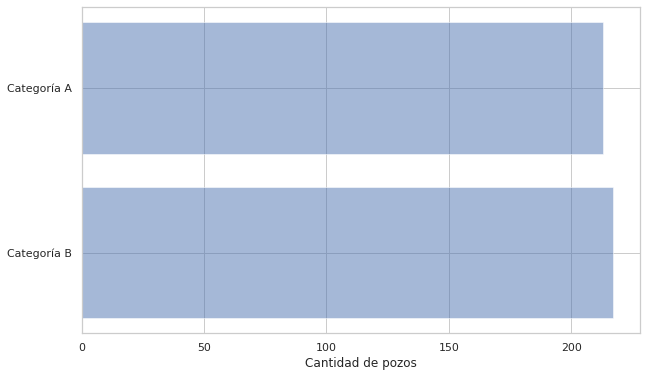

In [ ]:
plt.figure(figsize=(10,6))
objects = ("Categoría B", "Categoría A")
y_pos = np.arange(len(objects))
cantidad = clases['counts']
plt.barh(y_pos, cantidad, align='center', alpha=0.5)
plt.yticks(y_pos, objects, fontname="Times New Roman")
plt.xlabel('Cantidad de pozos', fontname="Times New Roman")

##### b.) Determinación de hiperparámetros más adecuados
Nuevamente, se realiza utilizando validación cruzada de 4 grupos

In [ ]:
#Parámetros a iterar
n_estimators = list(range (200, 1100, 100))
criterion=['gini', 'entropy']
max_depth = list(range (1, 15, 1))
max_features=["sqrt", "log2"]
hyperF = dict(n_estimators = n_estimators, 
              max_depth = max_depth,  
              max_features=max_features)

#Optimización iterativa del modelo utilizando validación cruzada
forest = RandomForestClassifier(random_state = 0)
gridF = GridSearchCV(forest, hyperF, cv = 4, verbose = 1, n_jobs = -1,
                     scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                     refit='accuracy')
bestF = gridF.fit(X_train_norm, y_train)

#Evaluación de datos de evaluación
y_pred_test = bestF.predict(X_test_norm)
metricas(y_test,y_pred_test)

Fitting 4 folds for each of 252 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed: 14.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.7790697674418605
[[30  9]
 [10 37]]
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        39
           1       0.80      0.79      0.80        47

    accuracy                           0.78        86
   macro avg       0.78      0.78      0.78        86
weighted avg       0.78      0.78      0.78        86



In [ ]:
gridF.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

##### c.) Exatitud, puntaje F1 e importancia de variables
Se determinó el desempeño del modelo según las métricas no dependientes del umbral (exactitud y puntaje F1). Asimismo, se presentan las variables en orden creciente

0.7790697674418605
[[30  9]
 [10 37]]
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        39
           1       0.80      0.79      0.80        47

    accuracy                           0.78        86
   macro avg       0.78      0.78      0.78        86
weighted avg       0.78      0.78      0.78        86



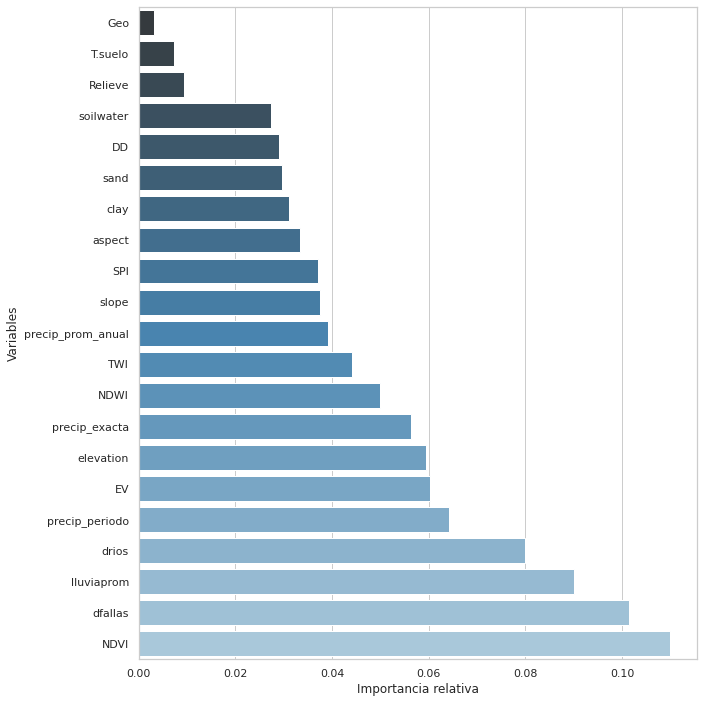

In [ ]:
model = RandomForestClassifier(n_estimators=300,
                               criterion="gini",
                               max_depth=7,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               min_weight_fraction_leaf=0,
                               max_features = "sqrt",
                               max_leaf_nodes=None,
                               min_impurity_decrease=0,
                               bootstrap = True,
                               oob_score=True,
                               n_jobs=None,
                               random_state=0,
                               verbose=0,
                               warm_start=False,
                               class_weight=None,
                               ccp_alpha=0,
                               max_samples=None)       
model.fit(X_train_norm, y_train.values.ravel())
y_pred_test = model.predict(X_test_norm)
metricas(y_test,y_pred_test)
importances = model.feature_importances_
indices = np.argsort(importances)
impplot=pd.DataFrame({'Variables':[X_clust.columns[i] for i in indices], 
                      'Importancia relativa': importances[indices]})
sn.set(rc={'figure.figsize':(10,12)}, font='Times New Roman',style="whitegrid")
ax = sn.barplot(y='Variables',x='Importancia relativa', data=impplot,palette='Blues_d')

##### d) Construcción de curvas ROC
Se computaron las curvas ROC por categoría para analizar el desempeño del modelo independientemente del umbral de decisión seleccionado. En simultáneo, se calcularon los umbrales óptimos.


Para el problema de clasificación binaria
El umbral más adecuado según el máximo índice de Youden es 0.556 con un valor de 0.595
El umbral más adecuado según la mínima distancia es 0.423 con un valor de 0.297


<Figure size 720x864 with 0 Axes>

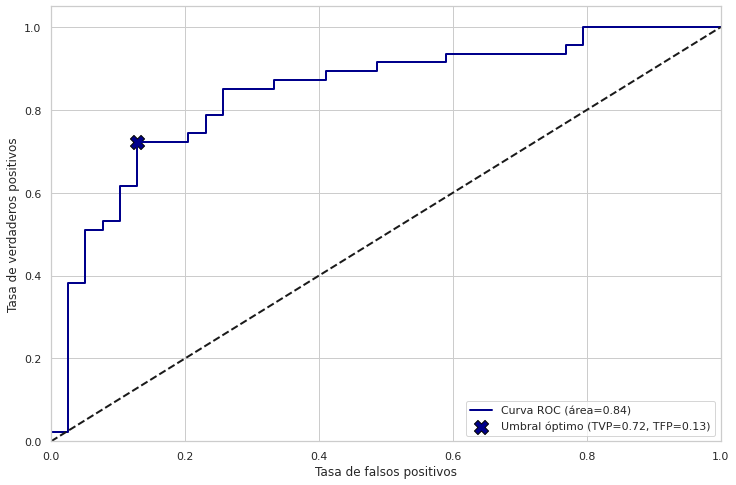

In [ ]:
y_score = model.predict_proba(X_test_norm)
fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)
youden = tpr-fpr
distance =np.power((np.power(1-tpr,2)+np.power(fpr,2)), 0.5)
youdenthr = thr[np.argmax(youden)]
youdenmax =  youden.max()
distthr = thr[np.argmin(distance)]
distmin =  distance.min()  
print("Para el problema de clasificación binaria")
print("El umbral más adecuado según el máximo índice de Youden es {:.3f} con un valor de {:.3f}".format(youdenthr, youdenmax))
print("El umbral más adecuado según la mínima distancia es {:.3f} con un valor de {:.3f}".format(distthr, distmin))

plt.figure()
plt.subplots(figsize=(12,8))
plt.plot(fpr, tpr, color="darkblue", lw=2, label='Curva ROC (área={:.2f})'.format(roc_auc))
ymax = tpr[np.argmax(youden)]
xmax = fpr[np.argmax(youden)]
plt.scatter(xmax, ymax, color="darkblue", marker="X", s=200, edgecolors="black",
            label="Umbral óptimo (TVP={:.2f}, TFP={:.2f})".format(tpr[np.argmax(youden)], fpr[np.argmax(youden)]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.legend(loc="lower right")
plt.show()


### 2.2) Modelo de redes neuronales

Debido a la naturaleza estocástica de estos modelos, es probable que los resultados obtenidos en cada iteración se diferencien ligeramente de los presentados en el escrito. Se incluyó una función para disminuir esta aleatoriedad al mínimo.

#### 2.2.1) Definiciones preliminares

##### a) Definición de bases de datos con origen

In [ ]:
con_origen=pd.concat([X_ann, df[['origen']]], axis=1)
ycon_origen=pd.concat([Y, df[['origen']]], axis=1)

##### b) Cálculo de métricas rápidas

In [ ]:
def metricas(y_test,y_pred_test):
  print (accuracy_score(y_test,y_pred_test))
  print(confusion_matrix(y_test,y_pred_test))
  print(classification_report(y_test,y_pred_test))

##### c) Función para anotar gráficas

In [ ]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

##### d) Definición de función de clasificación para redes neuronales
Para facilitar la construcción de modelos, se creó la funcuón 'classification_model'. Esta recibe como inputs el número de neuronas por capa oculta, el número de capas ocultas y la fracción de dropout que se desea emplear en la capa de entrada. Asimismo, se definió la función 'reset_seed' para minimizar la aleatoriedad involucrada en el algoritmo de redes neuronales y ser capaces de recrear los resultados obtenidos. 

In [ ]:
# define classification model
def classification_model(nneur,nhl,drp,reg):
    numfeat=X_clust.shape[1]
    numclass=Y_clust.shape[1]
    # create model
    model = Sequential()
    if drp  != 0:
      model.add(Dropout(drp, input_shape=(numfeat,)))
      if reg=="l1":
        model.add(Dense(numfeat, activation='relu', kernel_constraint=maxnorm(3), kernel_regularizer='l1'))
      elif reg=="l2":
        model.add(Dense(numfeat, activation='relu', kernel_constraint=maxnorm(3), kernel_regularizer='l2'))
      elif reg=="l1_l2":
        model.add(Dense(numfeat, activation='relu', kernel_constraint=maxnorm(3), kernel_regularizer='l1_l2'))
      else:
        model.add(Dense(numfeat, activation='relu', kernel_constraint=maxnorm(3)))
    else:
      model.add(Dense(nneur, input_dim=numfeat, activation='relu'))
    for i in range(nhl):
      model.add(Dense(nneur, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(numclass, activation='softmax'))
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(0)
    np.random.seed(1)
    random.seed(1)
    if tf.__version__[0] == '2':
        tf.random.set_seed(1)
    else:
        tf.set_random_seed(1)
    print("RANDOM SEEDS RESET")

##### e) Definición de función para entrenamiento de modelo y análisis
Se creó la función 'annmodel' basada en la función 'classification_model' para incluir el número de épocas, la presencia de gráficos, métricas y la curva AUROC (estos 3 últimos se presentan si se da como input el valor de True). De esta manera se facilitó el proceso de optimización del modelo predictivo.

In [ ]:
def annmodel(nneur,nepoc,nhl,drp, graficos, metrics, auroc, reg):
  reset_seeds()
  # entrenar modelo usando CV con 4 Folds
  n_split=4
  acc=[]
  f1=[]
  for train_index,test_index in KFold(n_split).split(X_train_norm):
    model=classification_model(nneur, nhl, drp, reg)
    x_trainfold,x_testfold=X_train_norm.to_numpy()[train_index],X_train_norm.to_numpy()[test_index]
    y_trainfold,y_testfold=y_train[train_index],y_train[test_index]
    history=model.fit(x_trainfold, y_trainfold, validation_data=(x_testfold, y_testfold), epochs=nepoc, verbose=0, shuffle=False)
    print('Model evaluation ',model.evaluate(x_testfold,y_testfold))
    y_testfoldpred=model.predict(x_testfold)
    acc.append(accuracy_score(y_testfold.argmax(axis=1),y_testfoldpred.argmax(axis=1)))
    f1.append(f1_score(y_testfold.argmax(axis=1),y_testfoldpred.argmax(axis=1), average="weighted"))
    if graficos==True:
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
      ax1.plot(history.history['loss'], label='Entrenamiento')
      ax1.plot(history.history['val_loss'], label='Validación')
      ax1.set_xlabel('Número de épocas'); ax1.set_ylabel('Pérdida')
      ax2.plot(history.history['categorical_accuracy'], label='Entrenamiento')
      ax2.plot(history.history['val_categorical_accuracy'], label='Validación')
      ax2.set_xlabel('Número de épocas'); ax2.set_ylabel('Exactitud')
      for ax in (ax1, ax2): ax.legend()
  print("La exactitud promedio de la validación cruzada es {:.3f}".format(np.mean(acc)))
  print("El puntaje F1 promedio de la validación cruzada es {:.3f}".format(np.mean(f1)))
  model=classification_model(nneur, nhl, drp, reg)

  # Crear modelo definitivo
  history=model.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=nepoc, verbose=0, shuffle=False)

  # Datos de evaluacion
  if metrics==True:
    y_pred_test=model.predict(X_test_norm)
    print(metricas(y_test.argmax(axis=1),y_pred_test.argmax(axis=1)))

  if auroc==True:
    if y_train.shape[1]==3:
      y_score=model.predict(X_test_norm)
      n_classes=3
      lw=2
      # Compute ROC curve and ROC area for each class
      fpr = dict()
      tpr = dict()
      roc_auc = dict()
      thr=dict()
      youden = dict()
      distance = dict()
      for i in range(n_classes):
        fpr[i], tpr[i], thr[i] = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        youden[i] = tpr[i]-fpr[i]
        distance[i] =np.power((np.power(1-tpr[i],2)+np.power(fpr[i],2)), 0.5)
        youdenthr = thr[i][np.argmax(youden[i])]
        youdenmax =  youden[i].max()
        distthr = thr[i][np.argmin(distance[i])]
        distmin =  distance[i].min()  
        print("Para la clase {0}:".format(["C", "B", "A"][i]))
        print("El umbral más adecuado según el máximo índice de Youden es {:.3f} con un valor de {:.3f}".format(youdenthr, youdenmax))
        print("El umbral más adecuado según la mínima distancia es {:.3f} con un valor de {:.3f}".format(distthr, distmin))
        
      # Compute micro-average ROC curve and ROC area
      fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
      roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
      from itertools import cycle

      plt.figure()
      plt.subplots(figsize=(12,8))
      plt.plot(fpr["micro"], tpr["micro"],
              label='Curva ROC promedio (área = {0:0.2f})'
                    ''.format(roc_auc["micro"]),
              color='deeppink', linestyle=':', linewidth=4)

      colors = cycle(['aqua', 'cornflowerblue', 'darkblue'])
      for i, color in zip(range(n_classes), colors):
          plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                  label='Curva ROC para la clase {0} (área = {1:0.2f})'
                  ''.format(["C", "B", "A"][i], roc_auc[i]))
          ymax = tpr[i][np.argmax(youden[i])]
          xmax = fpr[i][np.argmax(youden[i])]
          plt.scatter(xmax, ymax, color=color, marker="X", s=200, edgecolors="black",
                      label="Umbral óptimo para la clase {} (TVP={:.2f}, TFP={:.2f})".format(["C", "B", "A"][i],
                                                                                            tpr[i][np.argmax(youden[i])],
                                                                                            fpr[i][np.argmax(youden[i])]))
    else:
      lw=2
      y_score=model.predict(X_test_norm)
      fpr, tpr, thr = roc_curve(y_test[:, 1], y_score[:, 1])
      roc_auc = auc(fpr, tpr)
      youden = tpr-fpr
      distance =np.power((np.power(1-tpr,2)+np.power(fpr,2)), 0.5)
      youdenthr = thr[np.argmax(youden)]
      youdenmax =  youden.max()
      distthr = thr[np.argmin(distance)]
      distmin =  distance.min()  
      print("Para el problema de clasificación binaria")
      print("El umbral más adecuado según el máximo índice de Youden es {:.3f} con un valor de {:.3f}".format(youdenthr, youdenmax))
      print("El umbral más adecuado según la mínima distancia es {:.3f} con un valor de {:.3f}".format(distthr, distmin))

      plt.figure()
      plt.subplots(figsize=(12,8))
      plt.plot(fpr, tpr, color="darkblue", lw=2, label='Curva ROC (área={:.2f})'.format(roc_auc))
      ymax = tpr[np.argmax(youden)]
      xmax = fpr[np.argmax(youden)]
      plt.scatter(xmax, ymax, color="darkblue", marker="X", s=200, edgecolors="black",
            label="Umbral óptimo (TVP={:.2f}, TFP={:.2f})".format(tpr[np.argmax(youden)], fpr[np.argmax(youden)]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.legend(loc="lower right")
    plt.show()
    del model
    K.clear_session()
    reset_seeds()

#### 2.2.2) Modelo de redes neuronales sin segmentación geográfica en la costa y sin reducción de variables

##### a.) Selección de pozos

In [ ]:
origen=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru", "Lacramarca", "Santa", "Casma", 
        "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon", "Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", 
        "Acari", "Yauca"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=ycon_origen.loc[ycon_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=pd.qcut(Y_clust.values.flatten(), 3, labels=False)
Y_clust=to_categorical(Y_clust)
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=10)
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

##### b.) Determinación de hiperparámetro más adecuados con los datos de entrenamiento y validación, calculo de métricas con datos de evaluación



RANDOM SEEDS RESET
423/423 [==============================] - 0s 39us/step
Model evaluation  [3.752313161431757, 0.5579196214675903]
423/423 [==============================] - 0s 39us/step
Model evaluation  [3.1922920212396213, 0.588652491569519]
423/423 [==============================] - 0s 28us/step
Model evaluation  [3.801673421341195, 0.6052009463310242]
422/422 [==============================] - 0s 34us/step
Model evaluation  [3.4643771788237783, 0.5853080749511719]
La exactitud promedio de la validación cruzada es 0.584
El puntaje F1 promedio de la validación cruzada es 0.580
El AUROC promedio de la validación cruzada es 0.747
0.574468085106383
[[ 97  39  30]
 [ 42  35  28]
 [ 12  29 111]]
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       166
           1       0.34      0.33      0.34       105
           2       0.66      0.73      0.69       152

    accuracy                           0.57       423
   macro avg       0.55

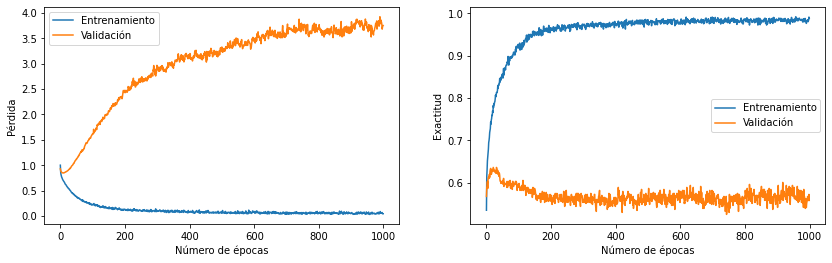

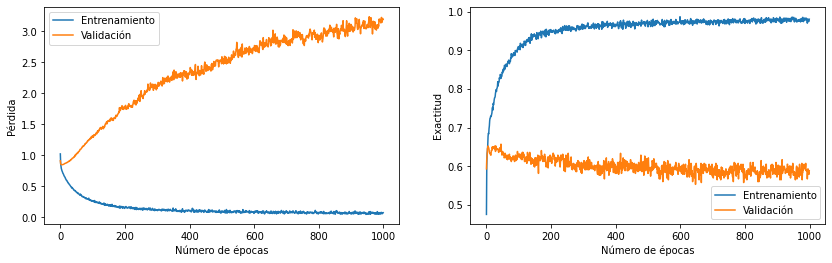

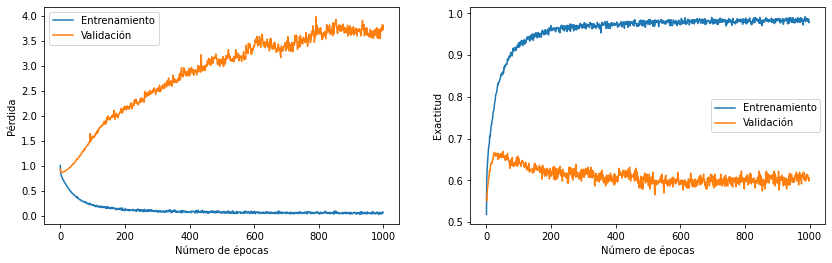

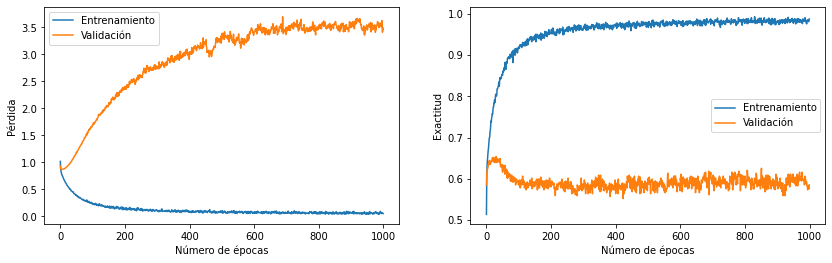

<Figure size 432x288 with 0 Axes>

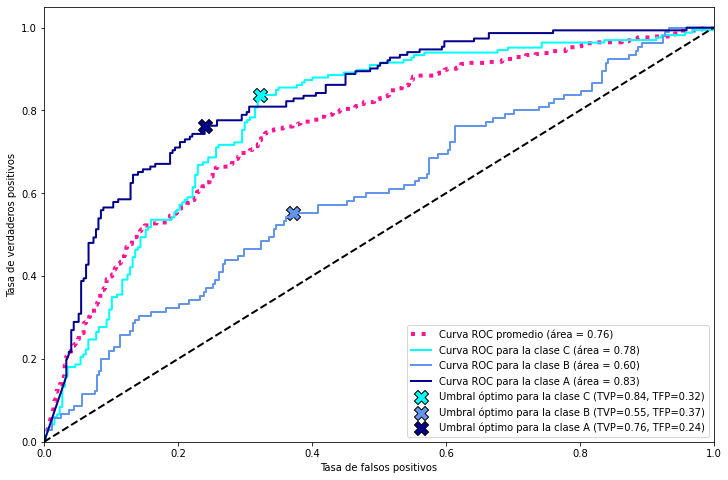

RANDOM SEEDS RESET


In [ ]:
annmodel(100,1000, 1,0.01, True, True, True, False)

RANDOM SEEDS RESET
423/423 [==============================] - 0s 48us/step
Model evaluation  [0.9160960095430378, 0.6453900933265686]
423/423 [==============================] - 0s 33us/step
Model evaluation  [0.8979443458236983, 0.6643025875091553]
423/423 [==============================] - 0s 33us/step
Model evaluation  [0.9090184396040355, 0.6643025875091553]
422/422 [==============================] - 0s 30us/step
Model evaluation  [0.8786841142234079, 0.670616090297699]
La exactitud promedio de la validación cruzada es 0.661
El puntaje F1 promedio de la validación cruzada es 0.647
El AUROC promedio de la validación cruzada es 0.796
0.6926713947990544
[[134  22  10]
 [ 44  45  16]
 [ 21  17 114]]
              precision    recall  f1-score   support

           0       0.67      0.81      0.73       166
           1       0.54      0.43      0.48       105
           2       0.81      0.75      0.78       152

    accuracy                           0.69       423
   macro avg       0

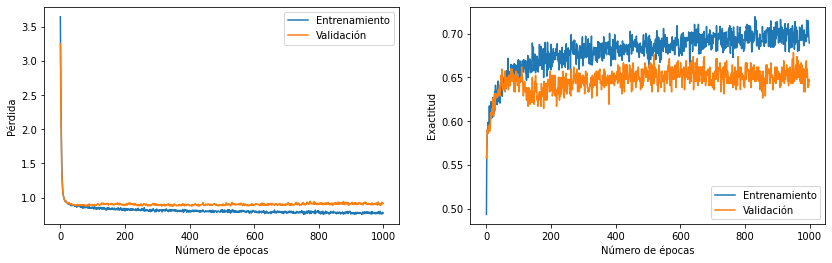

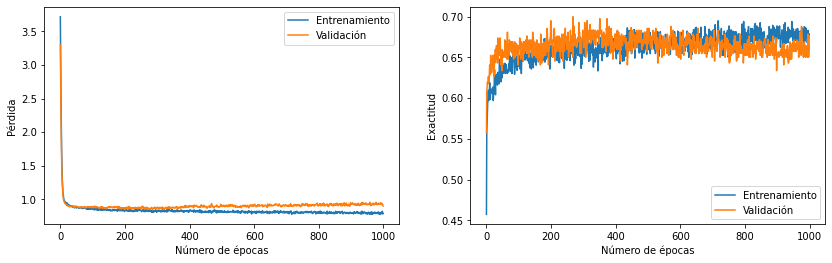

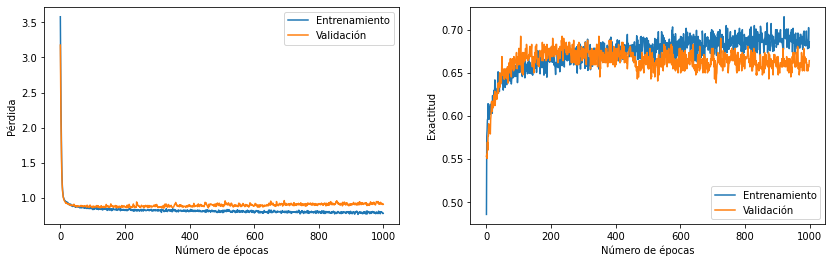

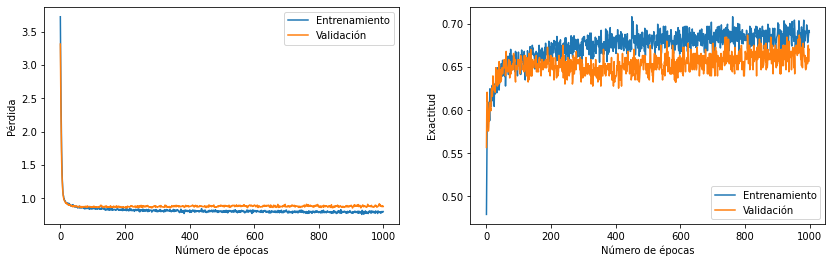

<Figure size 432x288 with 0 Axes>

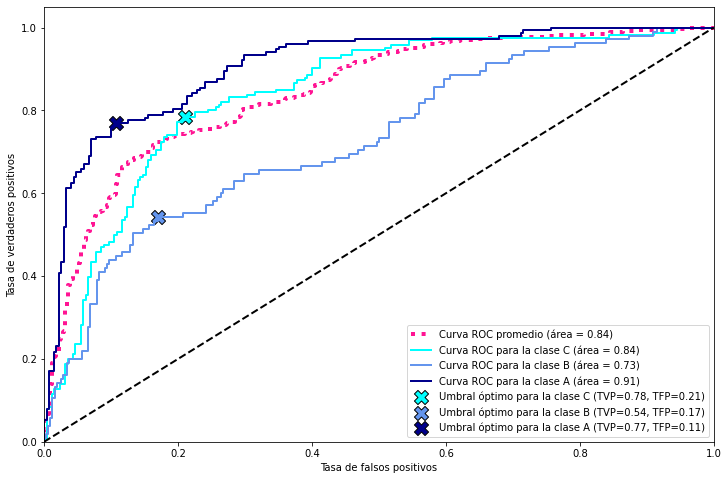

RANDOM SEEDS RESET


In [ ]:
annmodel(100,1000, 1,0.28, True, True, True, True)

##### c) Importancia de variables
Se analizó tomando en cuenta la varianza del peso de las neuronas asociadas a las variables independientes. Debido a que la inicialización de los modelos de RN es aleatoria, se optó por tomar el promedio de 20 iteraciones.

Accuracy: 0.6879432797431946 
 Error: 0.3120567202568054
Accuracy: 0.7068557739257812 
 Error: 0.29314422607421875
Accuracy: 0.7115839123725891 
 Error: 0.2884160876274109
Accuracy: 0.6784870028495789 
 Error: 0.32151299715042114
Accuracy: 0.6832151412963867 
 Error: 0.3167848587036133
Accuracy: 0.6808510422706604 
 Error: 0.3191489577293396
Accuracy: 0.6973995566368103 
 Error: 0.3026004433631897
Accuracy: 0.6690307259559631 
 Error: 0.33096927404403687
Accuracy: 0.6761229038238525 
 Error: 0.32387709617614746


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Accuracy: 0.6761229038238525 
 Error: 0.32387709617614746


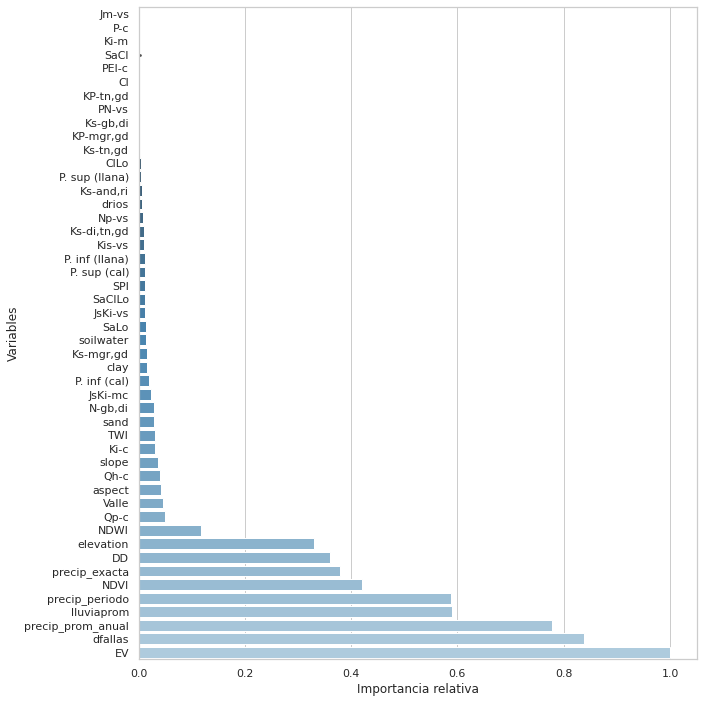

In [ ]:
imp=np.zeros(49)
for i in range(10):
  numfeat=X_clust.shape[1]
  numclass=Y_clust.shape[1]
  VIANN = VarImpVIANN(verbose=0)
  model = Sequential()
  model.add(Dense(100, activation='relu',input_shape=(numfeat,), kernel_constraint=maxnorm(3), kernel_regularizer='l1'))
  model.add(Dense(numclass, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  history=model.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000, verbose=0, callbacks = [VIANN])
  scores = model.evaluate(X_test_norm, y_test, verbose=0)
  print('Accuracy: {} \n Error: {}'.format(scores[1], 1 - scores[1])) 
  imp=imp+VIANN.varScores
importances=imp/max(imp)
indices = np.argsort(importances)

impplot=pd.DataFrame({'Variables':[X_clust.columns[i] for i in indices], 
                      'Importancia relativa': importances[indices]})
sn.set(rc={'figure.figsize':(10,12)}, font='Times New Roman',style="whitegrid")
ax = sn.barplot(y='Variables',x='Importancia relativa', data=impplot,palette='Blues_d')

#### 2.2.3) Modelo de redes neuronales sin segmentación geográfica en la costa con variables reducidas

##### a.) Selección de pozos y variables

In [ ]:
origen=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru", "Lacramarca", "Santa", "Casma", 
        "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon", "Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", 
        "Acari", "Yauca"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])
X_clust=X_clust[["aspect", "DD", "elevation", "NDWI", "precip_periodo","precip_exacta", "precip_prom_anual", "lluviaprom"]]
Y_clust=ycon_origen.loc[ycon_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=pd.qcut(Y_clust.values.flatten(), 3, labels=False)
Y_clust=to_categorical(Y_clust)
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=10)
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

##### b.) Determinación de hiperparámetro más adecuados con los datos de entrenamiento y validación, calculo de métricas con datos de evaluación

RANDOM SEEDS RESET
423/423 [==============================] - 0s 35us/step
Model evaluation  [0.905635914904006, 0.5910165309906006]
423/423 [==============================] - 0s 27us/step
Model evaluation  [0.9266512078314526, 0.6643025875091553]
423/423 [==============================] - 0s 34us/step
Model evaluation  [0.8791345456531425, 0.6264775395393372]
422/422 [==============================] - 0s 36us/step
Model evaluation  [0.858925152163935, 0.6516587734222412]
La exactitud promedio de la validación cruzada es 0.633
El puntaje F1 promedio de la validación cruzada es 0.625
El AUROC promedio de la validación cruzada es 0.774
0.6903073286052009
[[135  21  10]
 [ 38  50  17]
 [ 21  24 107]]
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       166
           1       0.53      0.48      0.50       105
           2       0.80      0.70      0.75       152

    accuracy                           0.69       423
   macro avg       0.

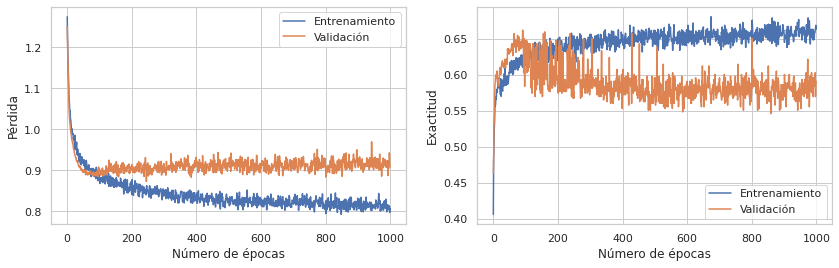

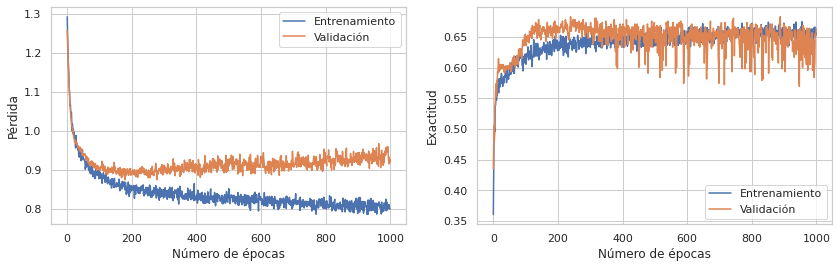

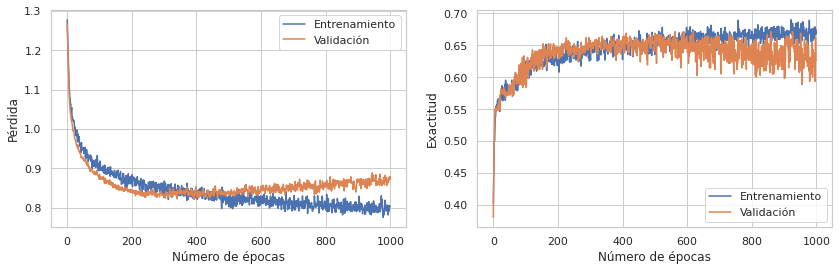

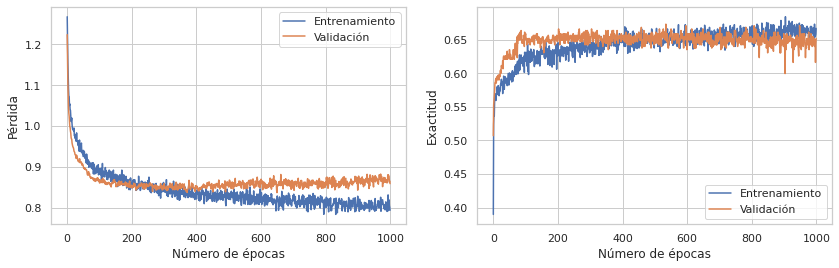

<Figure size 720x864 with 0 Axes>

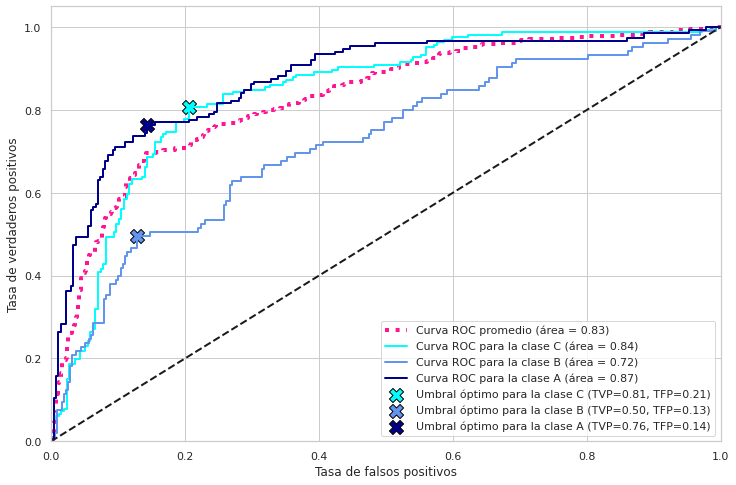

RANDOM SEEDS RESET


In [ ]:
annmodel(50,1000, 2,0.28, True, True, True, True)

##### c) Importancia de variables
Se analizó tomando en cuenta la varianza del peso de las neuronas asociadas a las variables independientes. Debido a que la inicialización de los modelos de RN es aleatoria, se optó por tomar el promedio de 20 iteraciones.

Accuracy: 0.6690307259559631 
 Error: 0.33096927404403687
Accuracy: 0.6619385480880737 
 Error: 0.33806145191192627
Accuracy: 0.6761229038238525 
 Error: 0.32387709617614746
Accuracy: 0.6761229038238525 
 Error: 0.32387709617614746
Accuracy: 0.6690307259559631 
 Error: 0.33096927404403687
Accuracy: 0.6784870028495789 
 Error: 0.32151299715042114
Accuracy: 0.6690307259559631 
 Error: 0.33096927404403687
Accuracy: 0.6643025875091553 
 Error: 0.3356974124908447
Accuracy: 0.6595744490623474 
 Error: 0.3404255509376526
Accuracy: 0.673758864402771 
 Error: 0.326241135597229


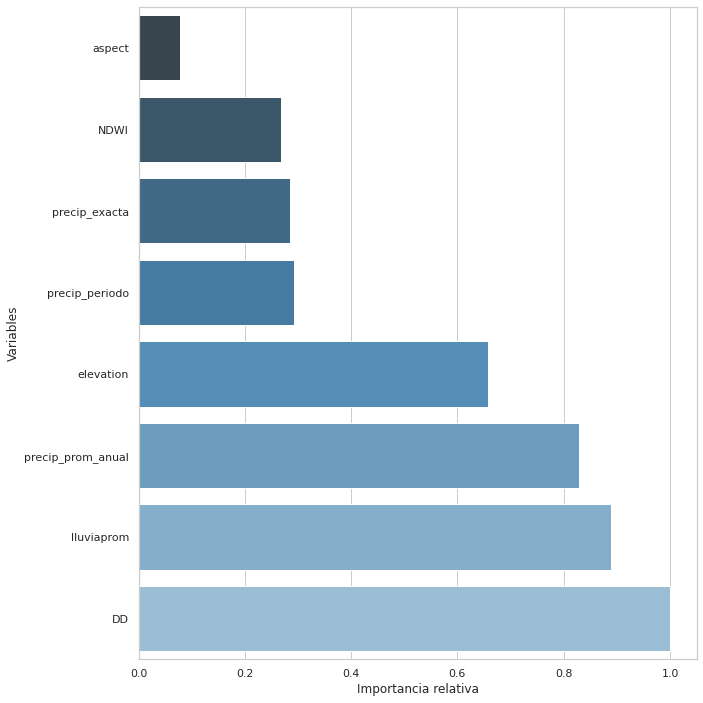

In [ ]:
imp=np.zeros(X_clust.shape[1])
for i in range(10):
  numfeat=X_clust.shape[1]
  numclass=Y_clust.shape[1]
  VIANN = VarImpVIANN(verbose=0)
  model = Sequential()
  model.add(Dense(50, activation='relu',input_shape=(numfeat,), kernel_constraint=maxnorm(3), kernel_regularizer='l1'))
  model.add(Dense(50, activation='relu', kernel_constraint=maxnorm(3)))
  model.add(Dense(numclass, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  history=model.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000, verbose=0, callbacks = [VIANN])
  scores = model.evaluate(X_test_norm, y_test, verbose=0)
  print('Accuracy: {} \n Error: {}'.format(scores[1], 1 - scores[1])) 
  imp=imp+VIANN.varScores
importances=imp/max(imp)
indices = np.argsort(importances)

impplot=pd.DataFrame({'Variables':[X_clust.columns[i] for i in indices], 
                      'Importancia relativa': importances[indices]})
sn.set(rc={'figure.figsize':(10,12)}, font='Times New Roman',style="whitegrid")
ax = sn.barplot(y='Variables',x='Importancia relativa', data=impplot,palette='Blues_d')

##### d) Análisis de precipitación

###### Periodo

RANDOM SEEDS RESET
423/423 [==============================] - 0s 32us/step
Model evaluation  [1.0313824781571157, 0.5059101581573486]
423/423 [==============================] - 0s 43us/step
Model evaluation  [0.9295235195903914, 0.5555555820465088]
423/423 [==============================] - 0s 35us/step
Model evaluation  [1.0393632006419748, 0.5815602540969849]
422/422 [==============================] - 0s 43us/step
Model evaluation  [0.9590711915662503, 0.5402843356132507]
La exactitud promedio de la validación cruzada es 0.546
El puntaje F1 promedio de la validación cruzada es 0.548
0.6690307328605201
[[129  21  16]
 [ 37  48  20]
 [ 24  22 106]]
              precision    recall  f1-score   support

           0       0.68      0.78      0.72       166
           1       0.53      0.46      0.49       105
           2       0.75      0.70      0.72       152

    accuracy                           0.67       423
   macro avg       0.65      0.64      0.65       423
weighted avg     

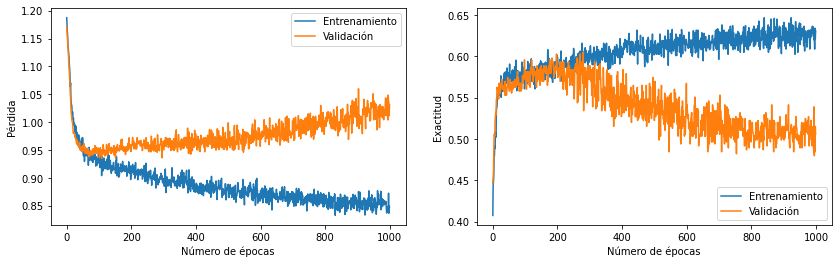

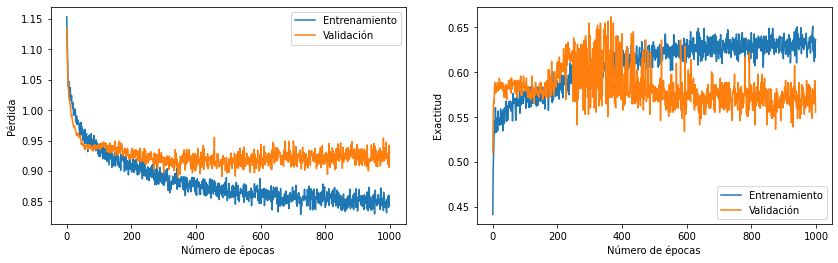

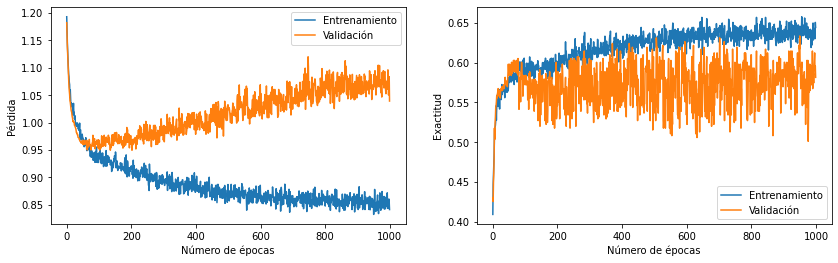

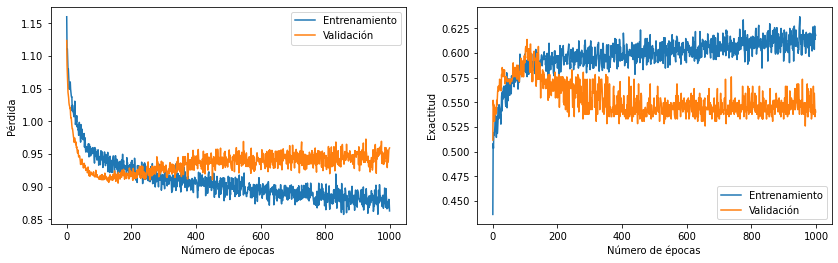

<Figure size 432x288 with 0 Axes>

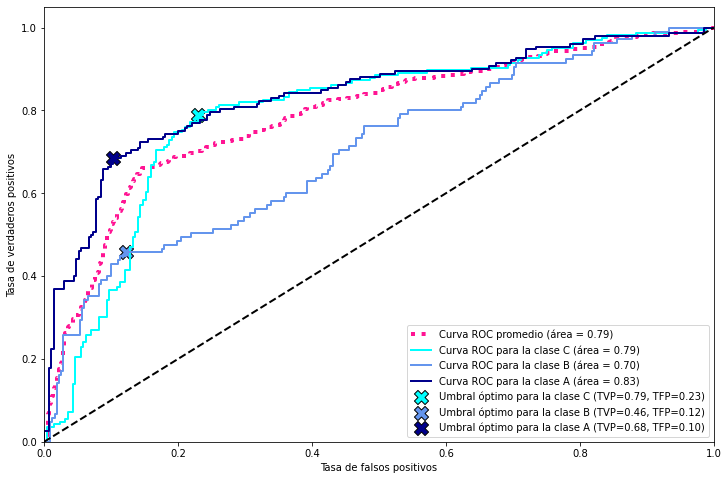

RANDOM SEEDS RESET


In [ ]:
origen=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru", "Lacramarca", "Santa", "Casma", 
        "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon", "Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", 
        "Acari", "Yauca"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])
X_clust=X_clust[["aspect", "DD", "elevation", "NDWI", "precip_periodo"]]
Y_clust=ycon_origen.loc[ycon_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=pd.qcut(Y_clust.values.flatten(), 3, labels=False)
Y_clust=to_categorical(Y_clust)
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=10)
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
annmodel(50,1000, 2,0.28, True, True, True, True)

###### Exacta


RANDOM SEEDS RESET
423/423 [==============================] - 0s 29us/step
Model evaluation  [1.0545277185473882, 0.5413711667060852]
423/423 [==============================] - 0s 35us/step
Model evaluation  [1.0142220805440951, 0.5177304744720459]
423/423 [==============================] - 0s 30us/step
Model evaluation  [0.9734839412337499, 0.5508274435997009]
422/422 [==============================] - 0s 46us/step
Model evaluation  [0.9410853169823145, 0.6279621124267578]
La exactitud promedio de la validación cruzada es 0.559
El puntaje F1 promedio de la validación cruzada es 0.556
0.6690307328605201
[[136  13  17]
 [ 46  40  19]
 [ 30  15 107]]
              precision    recall  f1-score   support

           0       0.64      0.82      0.72       166
           1       0.59      0.38      0.46       105
           2       0.75      0.70      0.73       152

    accuracy                           0.67       423
   macro avg       0.66      0.63      0.64       423
weighted avg     

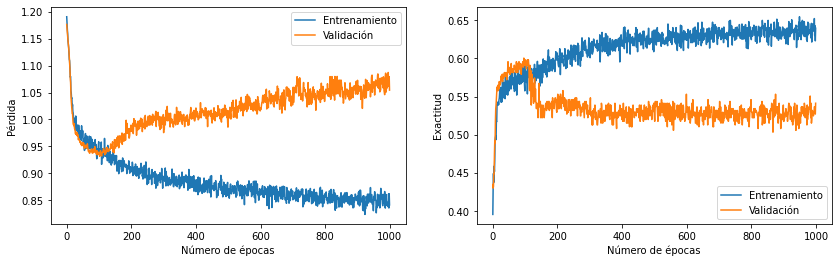

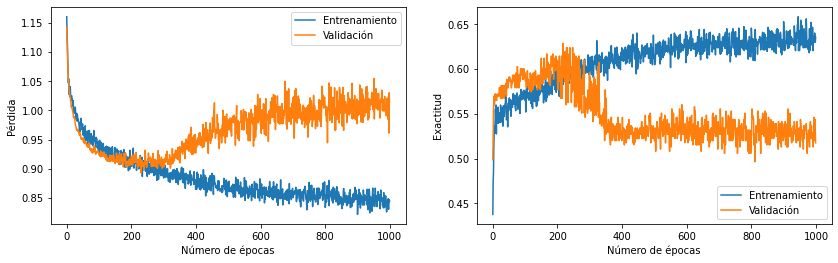

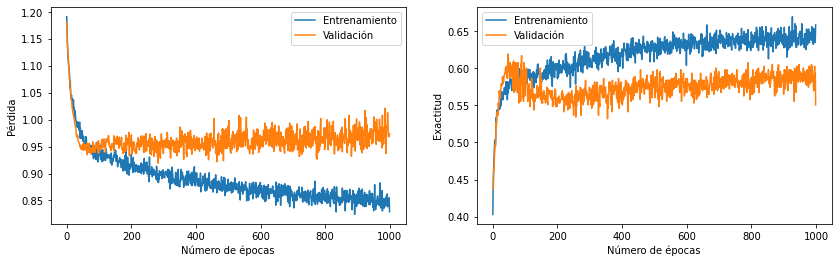

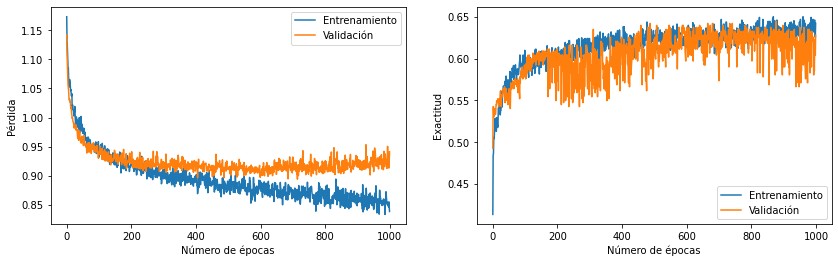

<Figure size 432x288 with 0 Axes>

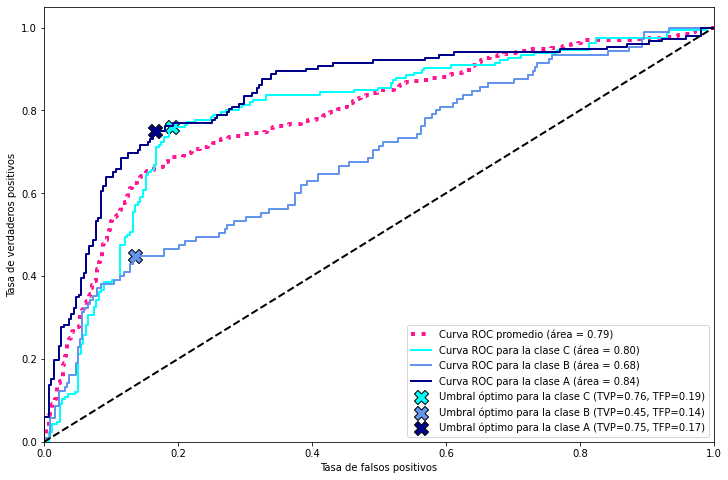

RANDOM SEEDS RESET


In [ ]:
origen=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru", "Lacramarca", "Santa", "Casma", 
        "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon", "Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", 
        "Acari", "Yauca"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])
X_clust=X_clust[["aspect", "DD", "elevation", "NDWI","precip_exacta"]]
Y_clust=ycon_origen.loc[ycon_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=pd.qcut(Y_clust.values.flatten(), 3, labels=False)
Y_clust=to_categorical(Y_clust)
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=10)
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
annmodel(50,1000, 2,0.28, True, True, True, True)

###### Prom anual

RANDOM SEEDS RESET
423/423 [==============================] - 0s 37us/step
Model evaluation  [0.9413300215070693, 0.5366430282592773]
423/423 [==============================] - 0s 31us/step
Model evaluation  [0.8720777784397135, 0.6477541327476501]
423/423 [==============================] - 0s 42us/step
Model evaluation  [0.9571674816997339, 0.6028369069099426]
422/422 [==============================] - 0s 35us/step
Model evaluation  [0.8951208938919537, 0.5876777172088623]
La exactitud promedio de la validación cruzada es 0.594
El puntaje F1 promedio de la validación cruzada es 0.593
0.6548463356973995
[[120  31  15]
 [ 40  45  20]
 [ 22  18 112]]
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       166
           1       0.48      0.43      0.45       105
           2       0.76      0.74      0.75       152

    accuracy                           0.65       423
   macro avg       0.63      0.63      0.63       423
weighted avg     

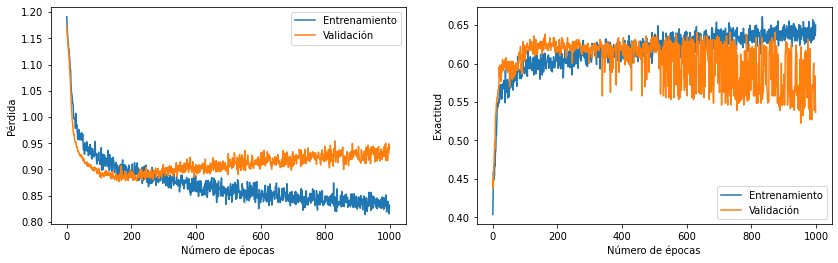

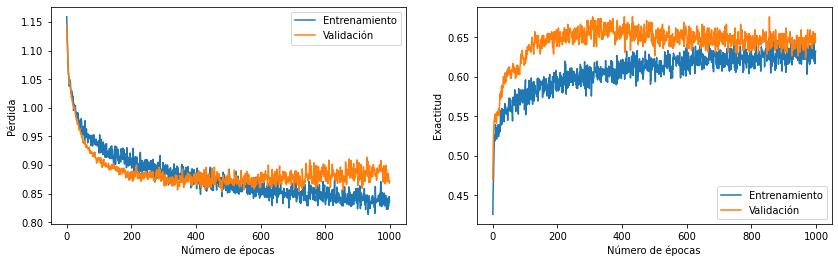

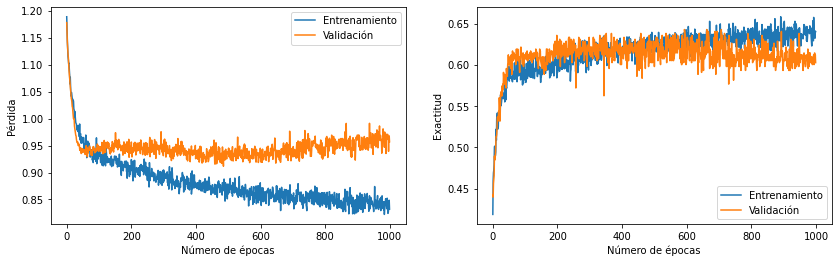

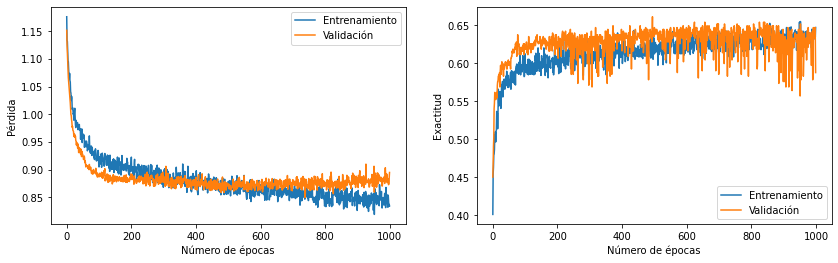

<Figure size 432x288 with 0 Axes>

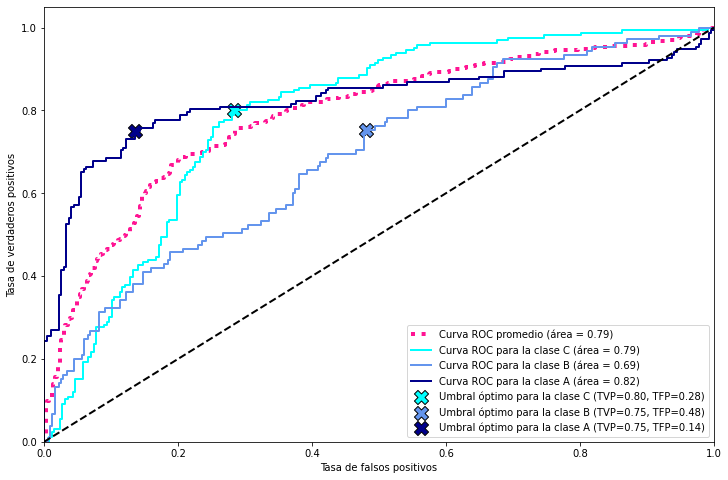

RANDOM SEEDS RESET


In [ ]:
origen=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru", "Lacramarca", "Santa", "Casma", 
        "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon", "Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", 
        "Acari", "Yauca"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])
X_clust=X_clust[["aspect", "DD", "elevation", "NDWI","precip_prom_anual"]]
Y_clust=ycon_origen.loc[ycon_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=pd.qcut(Y_clust.values.flatten(), 3, labels=False)
Y_clust=to_categorical(Y_clust)
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=10)
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
annmodel(50,1000, 2,0.28, True, True, True, True)

###### Histórico

RANDOM SEEDS RESET
423/423 [==============================] - 0s 38us/step
Model evaluation  [0.9579155626871907, 0.5248227119445801]
423/423 [==============================] - 0s 31us/step
Model evaluation  [0.8844089947693737, 0.6288415789604187]
423/423 [==============================] - 0s 33us/step
Model evaluation  [1.078250181308593, 0.5626477599143982]
422/422 [==============================] - 0s 38us/step
Model evaluation  [0.9275790557477146, 0.6113743782043457]
La exactitud promedio de la validación cruzada es 0.582
El puntaje F1 promedio de la validación cruzada es 0.577
0.6288416075650118
[[122  32  12]
 [ 44  45  16]
 [ 28  25  99]]
              precision    recall  f1-score   support

           0       0.63      0.73      0.68       166
           1       0.44      0.43      0.43       105
           2       0.78      0.65      0.71       152

    accuracy                           0.63       423
   macro avg       0.62      0.60      0.61       423
weighted avg      

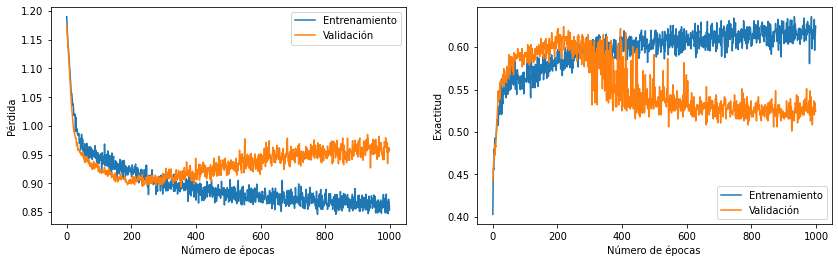

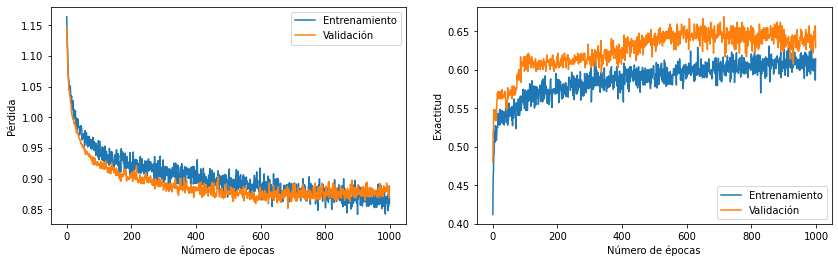

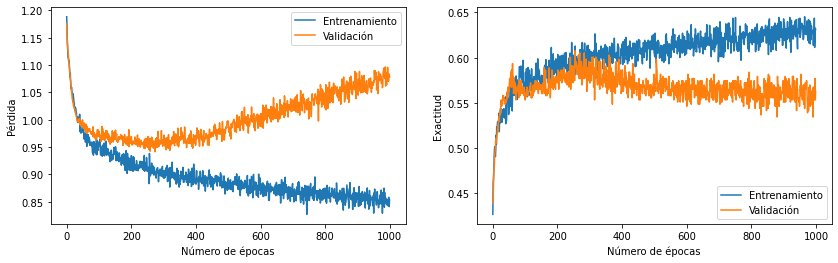

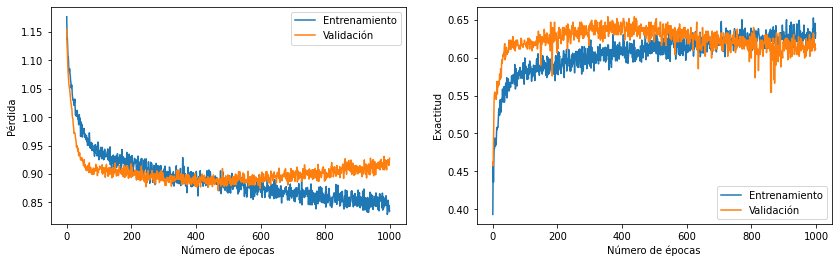

<Figure size 432x288 with 0 Axes>

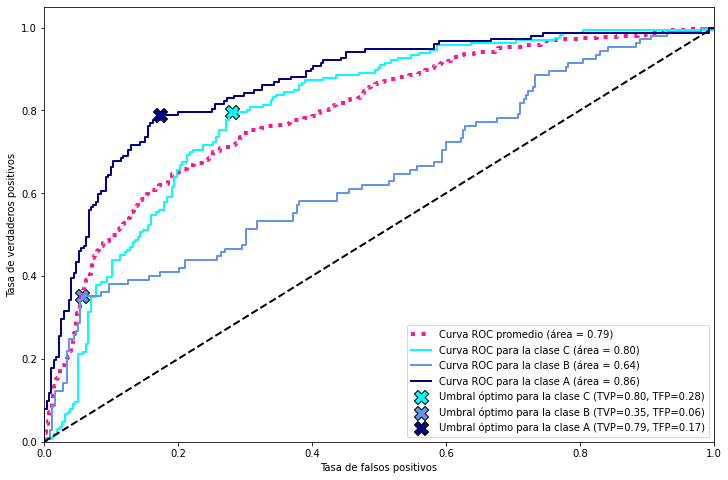

RANDOM SEEDS RESET


In [ ]:
origen=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru", "Lacramarca", "Santa", "Casma", 
        "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon", "Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", 
        "Acari", "Yauca"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])
X_clust=X_clust[["aspect", "DD", "elevation", "NDWI","lluviaprom"]]
Y_clust=ycon_origen.loc[ycon_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=pd.qcut(Y_clust.values.flatten(), 3, labels=False)
Y_clust=to_categorical(Y_clust)
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=10)
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
annmodel(50,1000, 2,0.28, True, True, True, True)

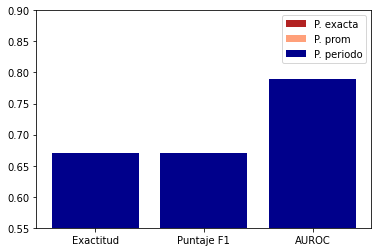

In [ ]:
#Exactitud#
exacta = {'Exactitud': 0.67, 'Puntaje F1': 0.66, 'AUROC': 0.79}
prom = {'Exactitud': 0.65, 'Puntaje F1': 0.65, 'AUROC': 0.79}
periodo = {'Exactitud': 0.67, 'Puntaje F1': 0.67, 'AUROC': 0.79}

names1 = list(exacta.keys())
values1 = list(exacta.values())
names2 = list(prom.keys())
values2 = list(prom.values())
baseline = list(periodo.keys())
baselinev = list(periodo.values())

axes = plt.gca()
axes.set_ylim([0.55,0.90])
plt.bar(names1, values1,color='firebrick', label="P. exacta")
plt.bar(names2, values2,color='lightsalmon', label="P. prom")
plt.bar(baseline, baselinev, color='darkblue', label='P. periodo')
plt.legend(loc="upper right")
plt.show()

In [ ]:
np.arange(3)

array([0, 1, 2])

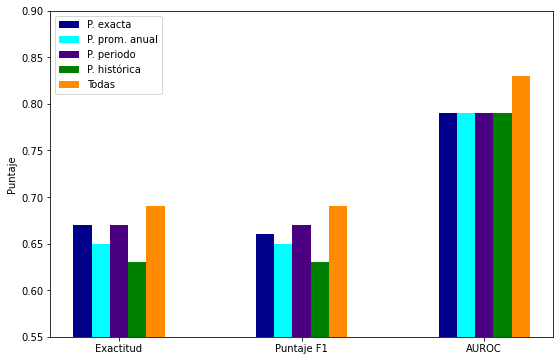

In [ ]:
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.1      # the width of the bars

#Exactitud#
exacta = {'Exactitud': 0.67, 'Puntaje F1': 0.66, 'AUROC': 0.79}
prom = {'Exactitud': 0.65, 'Puntaje F1': 0.65, 'AUROC': 0.79}
periodo = {'Exactitud': 0.67, 'Puntaje F1': 0.67, 'AUROC': 0.79}
hist = {'Exactitud': 0.63, 'Puntaje F1': 0.63, 'AUROC': 0.79}
comb = {'Exactitud': 0.69, 'Puntaje F1': 0.69, 'AUROC': 0.83}

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)


yvals = [0.67, 0.66, 0.79]
rects1 = ax.bar(ind-width, yvals, width, color='darkblue')
zvals = [0.65, 0.65, 0.79]
rects2 = ax.bar(ind, zvals, width, color='aqua')
kvals = [0.67, 0.67, 0.79]
rects3 = ax.bar(ind+width, kvals, width, color='indigo')
hist = [0.63, 0.63, 0.79]
rects4 = ax.bar(ind+width*2, hist, width, color='green')
comb = [0.69, 0.69, 0.83]
rects5 = ax.bar(ind+width*3, comb, width, color='darkorange')

ax.set_ylabel('Puntaje')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Exactitud', 'Puntaje F1', 'AUROC') )
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0], rects5[0] ), ('P. exacta', 'P. prom. anual', 'P. periodo', 'P. histórica', 'Todas') )
ax.set_ylim([0.55,0.90])

plt.show()

#### 2.2.3) Modelo de redes neuronales con segmentación geográfica para la costa sur

##### a.) Selección de pozos

In [ ]:
origen=["Lurin", "Chilca", "Mala", "Asia-Omas", "Chincha", "Palpa", "Acari", "Yauca"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=ycon_origen.loc[ycon_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=pd.qcut(Y_clust.values.flatten(), 3, labels=False)
Y_clust=to_categorical(Y_clust)
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=10)
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

##### a.) Exatitud, puntaje F1, curvas AUROC e información de entrenamiento
Se calcularon todos los índices de desempeño para el modelo, incluyendo su comportamiento a lo largo de las épocas de entrenamiento

RANDOM SEEDS RESET
259/259 [==============================] - 0s 31us/step
Model evaluation  [0.715384481726466, 0.7490347623825073]
258/258 [==============================] - 0s 32us/step
Model evaluation  [0.7467313300269519, 0.7441860437393188]
258/258 [==============================] - 0s 54us/step
Model evaluation  [0.9143877357475517, 0.7054263353347778]
258/258 [==============================] - 0s 38us/step
Model evaluation  [0.853317025557969, 0.7170542478561401]
La exactitud promedio de la validación cruzada es 0.729
El puntaje F1 promedio de la validación cruzada es 0.701
0.7258687258687259
[[117   2   5]
 [ 39  18   4]
 [ 15   6  53]]
              precision    recall  f1-score   support

           0       0.68      0.94      0.79       124
           1       0.69      0.30      0.41        61
           2       0.85      0.72      0.78        74

    accuracy                           0.73       259
   macro avg       0.74      0.65      0.66       259
weighted avg       

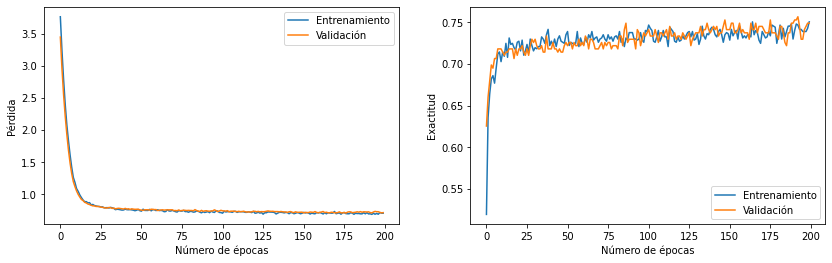

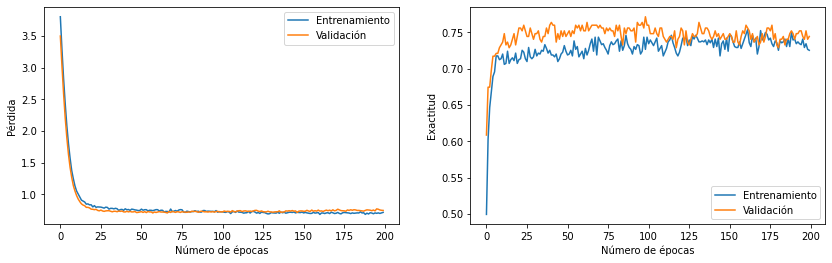

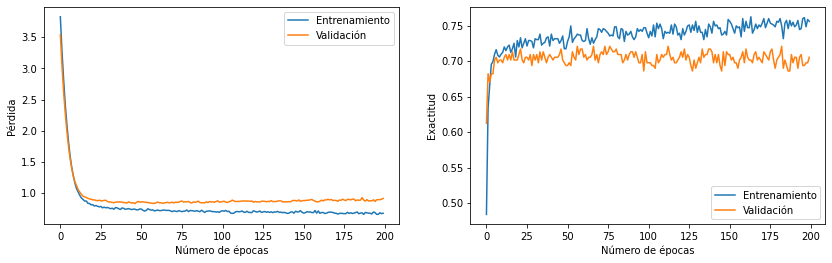

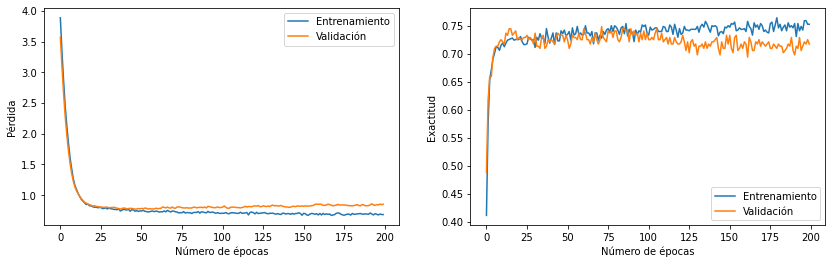

<Figure size 432x288 with 0 Axes>

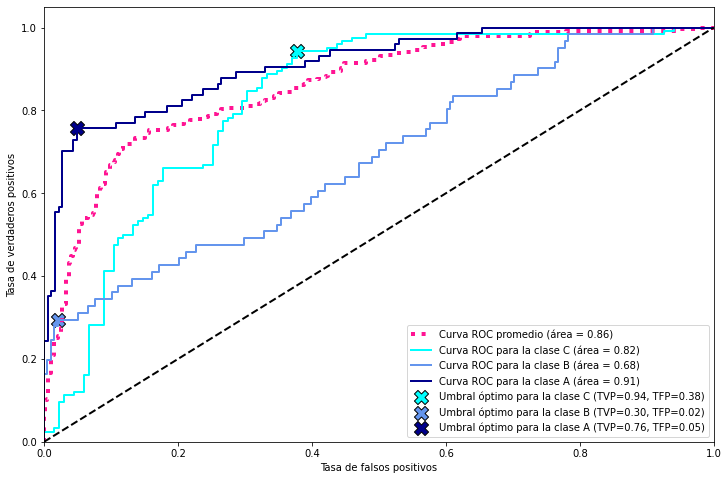

RANDOM SEEDS RESET


In [ ]:
annmodel(25,200,2,0.25, True, True, True, "l1")

RANDOM SEEDS RESET
259/259 [==============================] - 0s 39us/step
Model evaluation  [0.7743375287553058, 0.7451737523078918]
258/258 [==============================] - 0s 38us/step
Model evaluation  [0.8504249236380407, 0.7325581312179565]
258/258 [==============================] - 0s 29us/step
Model evaluation  [1.139397641947103, 0.682170569896698]
258/258 [==============================] - 0s 36us/step
Model evaluation  [0.911230956861215, 0.7054263353347778]
La exactitud promedio de la validación cruzada es 0.716
El puntaje F1 promedio de la validación cruzada es 0.694
0.722007722007722
[[113   6   5]
 [ 36  20   5]
 [ 14   6  54]]
              precision    recall  f1-score   support

           0       0.69      0.91      0.79       124
           1       0.62      0.33      0.43        61
           2       0.84      0.73      0.78        74

    accuracy                           0.72       259
   macro avg       0.72      0.66      0.67       259
weighted avg       0.

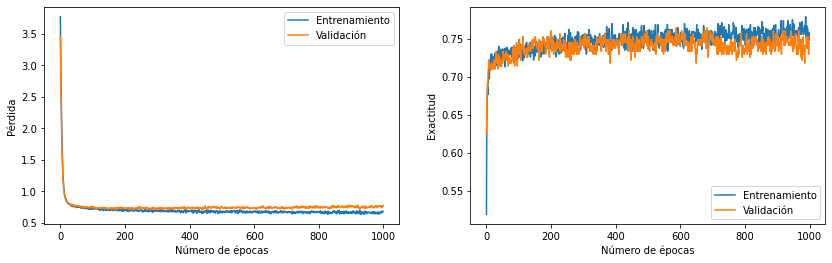

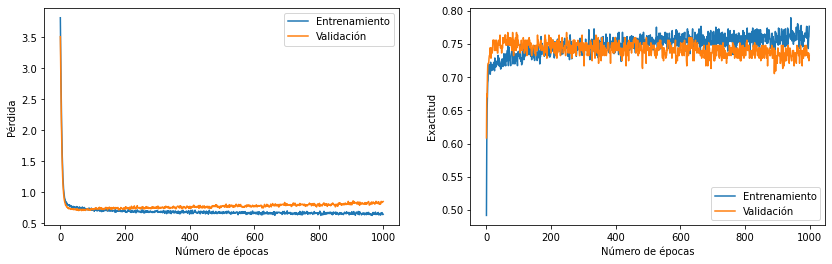

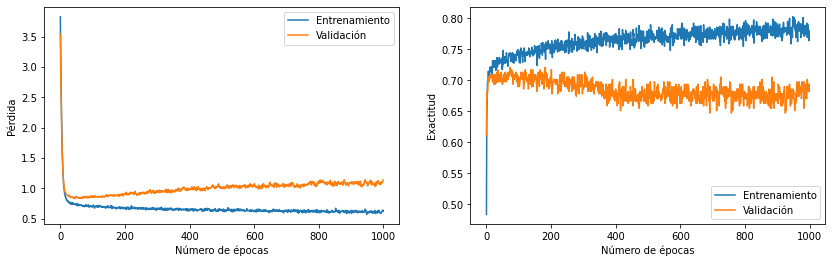

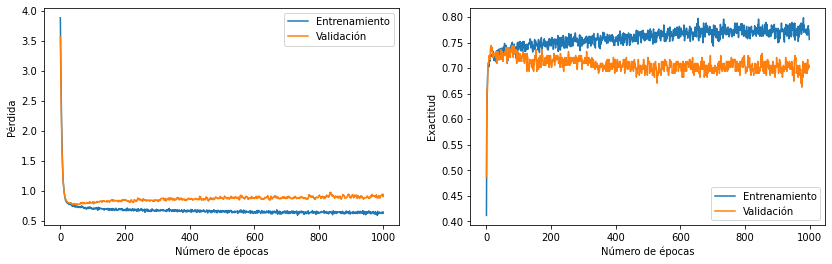

<Figure size 432x288 with 0 Axes>

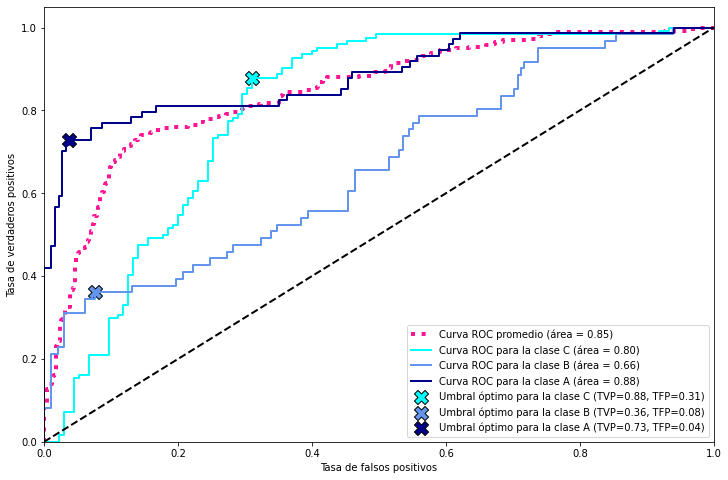

RANDOM SEEDS RESET


In [ ]:
annmodel(25,1000,2,0.25, True, True, True, "l1")

#### 2.2.4) Modelo de redes neuronales con segmentación geográfica para la costa centro

##### a.) Selección de pozos

In [ ]:
origen=["Lacramarca", "Santa", "Casma", "Huarmey", "Pativilca", "Supe", "Huaura", "Chillon"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=ycon_origen.loc[ycon_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=pd.qcut(Y_clust.values.flatten(), 2, labels=False)
Y_clust=to_categorical(Y_clust)
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=10)
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

##### b.) Exatitud, puntaje F1, curvas AUROC e información de entrenamiento
Se calcularon todos los índices de desempeño para el modelo, incluyendo su comportamiento a lo largo de las épocas de entrenamiento. Se tuvo que emplear las variables reducidas puesto que sino se presentaba sobre-entrenamiento en el modelo.

RANDOM SEEDS RESET
79/79 [==============================] - 0s 70us/step
Model evaluation  [0.9994382284864595, 0.7594936490058899]
78/78 [==============================] - 0s 77us/step
Model evaluation  [1.0560188874220238, 0.6666666865348816]
78/78 [==============================] - 0s 77us/step
Model evaluation  [1.302654770704416, 0.692307710647583]
78/78 [==============================] - 0s 37us/step
Model evaluation  [1.169720423527253, 0.6794871687889099]
La exactitud promedio de la validación cruzada es 0.699
El puntaje F1 promedio de la validación cruzada es 0.694
0.7215189873417721
[[41  9]
 [13 16]]
              precision    recall  f1-score   support

           0       0.76      0.82      0.79        50
           1       0.64      0.55      0.59        29

    accuracy                           0.72        79
   macro avg       0.70      0.69      0.69        79
weighted avg       0.72      0.72      0.72        79

None
Para el problema de clasificación binaria
El umbr

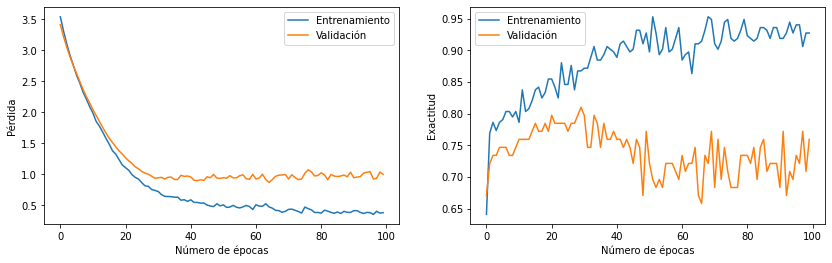

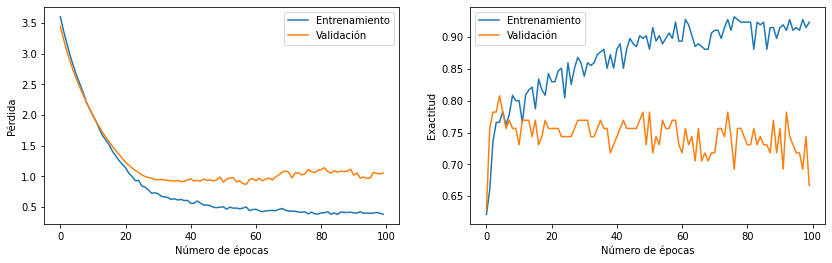

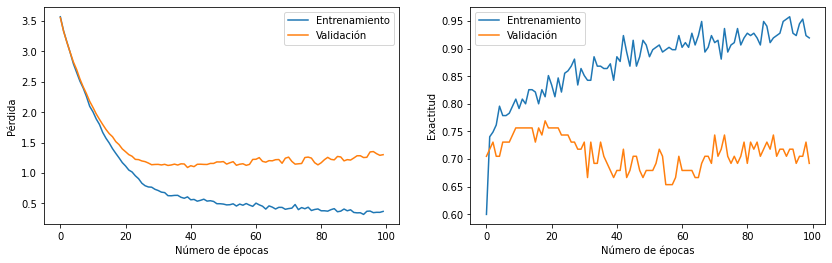

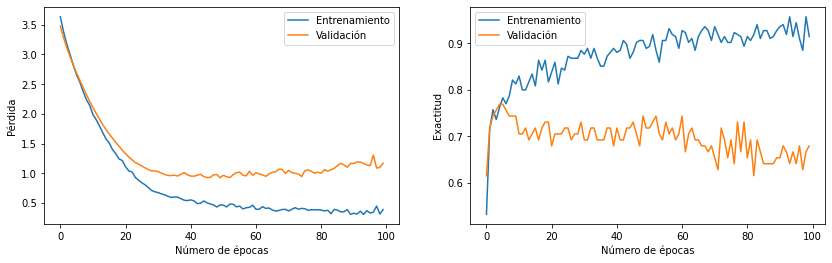

<Figure size 432x288 with 0 Axes>

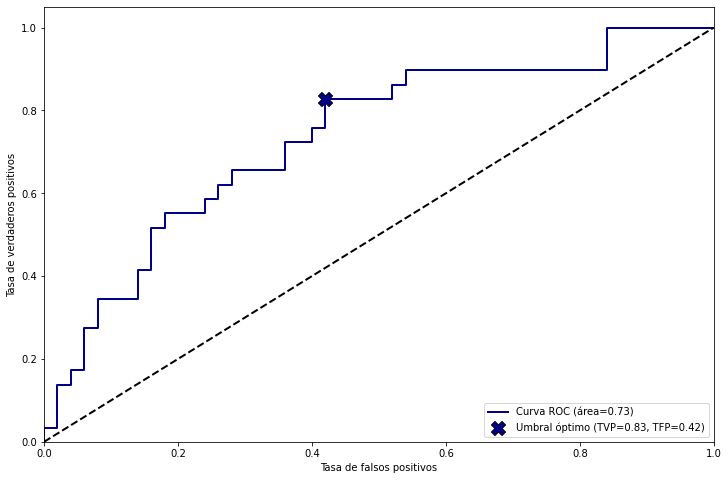

RANDOM SEEDS RESET


In [ ]:
annmodel(100,100,2,0.15, True, True, True, "l1")

#### 2.2.5) Modelo de redes neuronales con segmentación geográfica para la costa norte

##### a.) Selección de pozos



In [ ]:
origen=["MB Piura", "La Leche", "Chancay", "Jequetepeque", "Moche", "Viru"]
X_clust=con_origen.loc[con_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=ycon_origen.loc[ycon_origen['origen'].isin(origen)].drop(columns=['origen'])
Y_clust=pd.qcut(Y_clust.values.flatten(), 2, labels=False)
Y_clust=to_categorical(Y_clust)
X_train, X_test, y_train, y_test = train_test_split(X_clust, Y_clust, test_size=0.20, random_state=10)
scaler=StandardScaler()
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_norm=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

##### b.) Exatitud, puntaje F1, curvas AUROC e información de entrenamiento
Se calcularon todos los índices de desempeño para el modelo, incluyendo su comportamiento a lo largo de las épocas de entrenamiento. Se tuvo que emplear las variables reducidas puesto que sino se presentaba sobre-entrenamiento en el modelo.

RANDOM SEEDS RESET
86/86 [==============================] - 0s 36us/step
Model evaluation  [0.7718251319818719, 0.6627907156944275]
86/86 [==============================] - 0s 71us/step
Model evaluation  [0.6552611617154853, 0.7325581312179565]
86/86 [==============================] - 0s 34us/step
Model evaluation  [0.8642925342848135, 0.604651153087616]
86/86 [==============================] - 0s 69us/step
Model evaluation  [0.7165411100831143, 0.7325581312179565]
La exactitud promedio de la validación cruzada es 0.683
El puntaje F1 promedio de la validación cruzada es 0.682
0.7325581395348837
[[34 11]
 [12 29]]
              precision    recall  f1-score   support

           0       0.74      0.76      0.75        45
           1       0.72      0.71      0.72        41

    accuracy                           0.73        86
   macro avg       0.73      0.73      0.73        86
weighted avg       0.73      0.73      0.73        86

None
Para el problema de clasificación binaria
El um

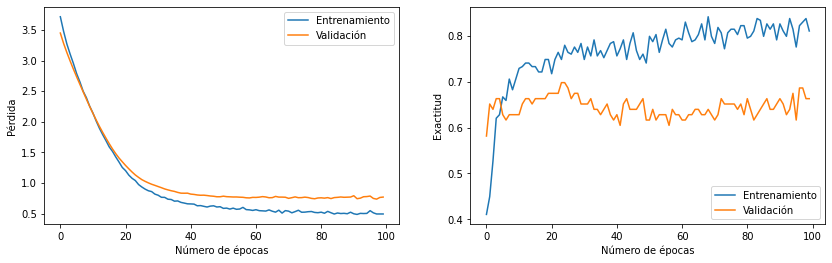

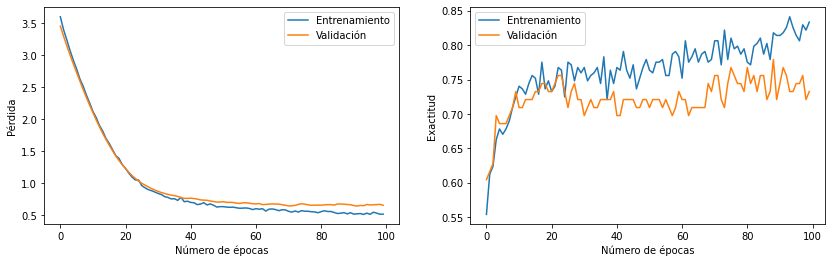

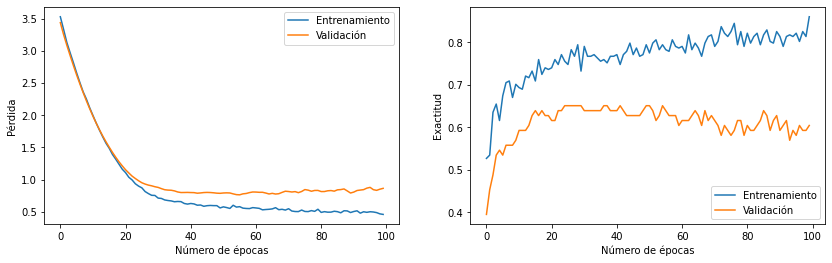

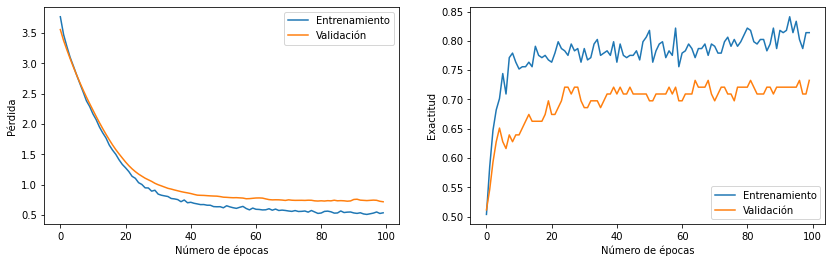

<Figure size 432x288 with 0 Axes>

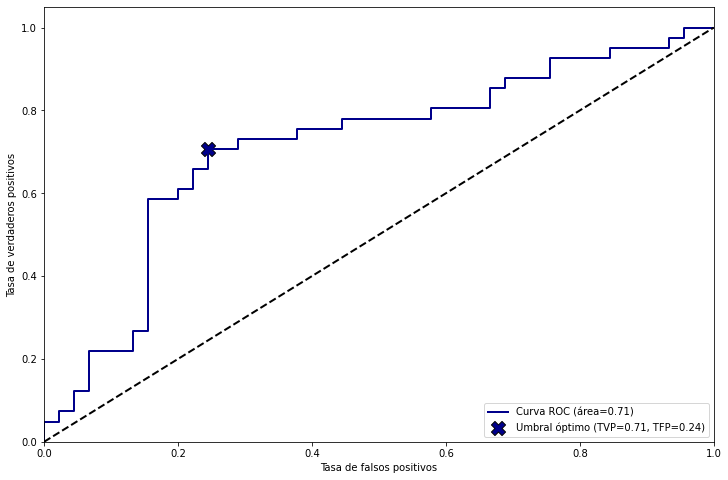

RANDOM SEEDS RESET


In [ ]:
annmodel(25,100,1,0.15, True, True, True, "l1")

## 3) Comparación de modelos predictivos
Para cada una de las métricas seleccionadas en la presente investigación, se presentan los resultados obtenidos junto con puntajes obtenidos en el estado del arte

### 3.1) Exactitud

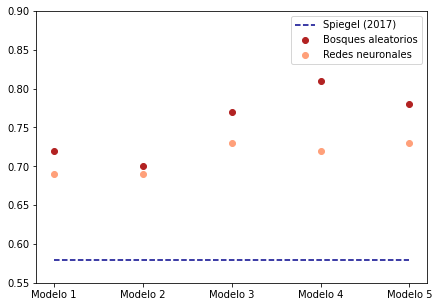

In [ ]:
#Exactitud#
data1 = {'Modelo 1': 0.72, 'Modelo 2': 0.70, 'Modelo 3': 0.77, 'Modelo 4': 0.81, 'Modelo 5': 0.78}
data2 = {'Modelo 1': 0.69, 'Modelo 2': 0.69, 'Modelo 3': 0.73, 'Modelo 4': 0.72, 'Modelo 5': 0.73}
comp = {'Modelo 1': 0.58, 'Modelo 2': 0.58, 'Modelo 3': 0.58, 'Modelo 4': 0.58, 'Modelo 5': 0.58}

names1 = list(data1.keys())
values1 = list(data1.values())
names2 = list(data2.keys())
values2 = list(data2.values())
baseline = list(comp.keys())
baselinev = list(comp.values())

axes = plt.figure(figsize=(7,5))
plt.ylim(0.55, 0.90)
plt.scatter(names1, values1,color='firebrick', label="Bosques aleatorios")
plt.scatter(names2, values2,color='lightsalmon', label="Redes neuronales")
plt.plot(baseline, baselinev, '--', color='darkblue', label='Spiegel (2017)')
plt.legend(loc="upper right")
plt.show()

### 3.1) Puntaje F1

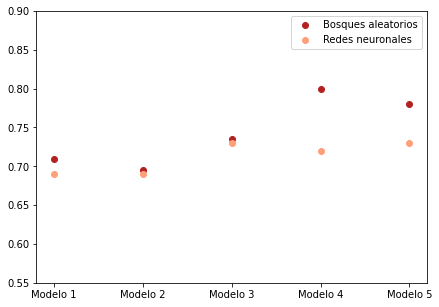

In [ ]:
#F1 score#
data1 = {'Modelo 1': 0.71, 'Modelo 2': 0.695, 'Modelo 3': 0.735, 'Modelo 4': 0.80, 'Modelo 5': 0.78}
data2 = {'Modelo 1': 0.69, 'Modelo 2': 0.69, 'Modelo 3': 0.73, 'Modelo 4': 0.72, 'Modelo 5': 0.73}

names1 = list(data1.keys())
values1 = list(data1.values())
names2 = list(data2.keys())
values2 = list(data2.values())

axes = plt.figure(figsize=(7,5))
plt.ylim(0.55, 0.90)
plt.scatter(names1, values1,color='firebrick', label="Bosques aleatorios")
plt.scatter(names2, values2,color='lightsalmon', label="Redes neuronales")
plt.legend(loc="upper right")
plt.show()

### 3.3) AUROC

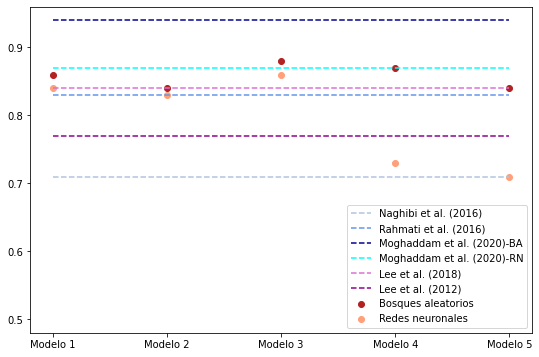

In [ ]:
#AUROC#
data1 = {'Modelo 1': 0.86, 'Modelo 2': 0.84, 'Modelo 3': 0.88, 'Modelo 4': 0.87, 'Modelo 5': 0.84}
data2 = {'Modelo 1': 0.84, 'Modelo 2': 0.83, 'Modelo 3': 0.86, 'Modelo 4': 0.73, 'Modelo 5': 0.71}

comp = {'Modelo 1': 0.71, 'Modelo 2': 0.71, 'Modelo 3': 0.71, 'Modelo 4': 0.71, 'Modelo 5': 0.71}
comp1 = {'Modelo 1': 0.83, 'Modelo 2': 0.83, 'Modelo 3': 0.83, 'Modelo 4': 0.83, 'Modelo 5': 0.83}
comp2 = {'Modelo 1': 0.94, 'Modelo 2': 0.94, 'Modelo 3': 0.94, 'Modelo 4': 0.94, 'Modelo 5': 0.94}
comp3 = {'Modelo 1': 0.87, 'Modelo 2': 0.87, 'Modelo 3': 0.87, 'Modelo 4': 0.87, 'Modelo 5': 0.87}
comp4 = {'Modelo 1': 0.84, 'Modelo 2': 0.84, 'Modelo 3': 0.84, 'Modelo 4': 0.84, 'Modelo 5': 0.84}
comp5 = {'Modelo 1': 0.77, 'Modelo 2': 0.77, 'Modelo 3': 0.77, 'Modelo 4': 0.77, 'Modelo 5': 0.77}

names1 = list(data1.keys())
values1 = list(data1.values())
names2 = list(data2.keys())
values2 = list(data2.values())
baseline = list(comp.keys())
baselinev = list(comp.values())
baseline1 = list(comp1.keys())
baselinev1 = list(comp1.values())
baseline2 = list(comp2.keys())
baselinev2 = list(comp2.values())
baseline3 = list(comp3.keys())
baselinev3 = list(comp3.values())
baseline4 = list(comp4.keys())
baselinev4 = list(comp4.values())
baseline5 = list(comp5.keys())
baselinev5 = list(comp5.values())

axes = plt.figure(figsize=(9,6))
plt.ylim(0.48, 0.96)
plt.scatter(names1, values1,color='firebrick', label="Bosques aleatorios")
plt.scatter(names2, values2,color='lightsalmon', label="Redes neuronales")
plt.plot(baseline, baselinev, '--', color='lightsteelblue', label='Naghibi et al. (2016)')
plt.plot(baseline1, baselinev1, '--', color='cornflowerblue', label='Rahmati et al. (2016)')
plt.plot(baseline2, baselinev2, '--', color='darkblue', label='Moghaddam et al. (2020)-BA')
plt.plot(baseline3, baselinev3, '--', color='cyan', label='Moghaddam et al. (2020)-RN')
plt.plot(baseline4, baselinev4, '--', color='orchid', label='Lee et al. (2018)')
plt.plot(baseline5, baselinev5, '--', color='darkmagenta', label='Lee et al. (2012)')
plt.legend(loc="lower right")
plt.show()

## 4) Generalización de modelos predictivos
Al haberse determinado que el modelo de bosques aleatorios presenta un mejor desempeño, este se empleo para clasificar a la totalidad del territorio peruano en Earth Engine. A continuación se presenta la exactitud con la cual predijo los pozos disponibles ubicados en la sierra y la selva para analizar la extrapolabilidad del modelo fuera de la costa.

In [ ]:
X_sierra=con_origen.loc[con_origen['origen']=="Ramis"].drop(columns=['origen'])
X_sierra=X_sierra[["aspect", "DD", "elevation", "NDWI", "precip_periodo","precip_exacta", "precip_prom_anual", "lluviaprom"]]
Y_sierra=ycon_origen.loc[ycon_origen['origen']=="Ramis"].drop(columns=['origen'])
X_selva=con_origen.loc[con_origen['origen']=="Iquitos"].drop(columns=['origen'])
X_selva=X_selva[["aspect", "DD", "elevation", "NDWI", "precip_periodo","precip_exacta", "precip_prom_anual", "lluviaprom"]]
Y_selva=ycon_origen.loc[ycon_origen['origen']=="Iquitos"].drop(columns=['origen'])
print('El modelo seleccionado predijo adecuadamente el {:.2f}% de pozos en la sierra del Perú.'
.format(accuracy_score(Y_sierra, model_selected.predict(X_sierra))*100)) 
print('El modelo seleccionado predijo adecuadamente el {:.2f}% de pozos en la selva del Perú.'
.format(accuracy_score(Y_selva, model_selected.predict(X_selva))*100)) 

El modelo seleccionado predijo adecuadamente el 83.33% de pozos en la sierra del Perú.
El modelo seleccionado predijo adecuadamente el 100.00% de pozos en la selva del Perú.
